# To 호현

- 기본 라이브러리 호출

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import pickle
import sys

from konlpy.tag import Kkma, Okt
import gc

import re
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

- 감정 사전 호출

In [5]:
from ksenticnet_kaist import *

ksenticnet = get_ksenticnet()

keys = list(ksenticnet.keys())
senticvals = [[float(i) for i in val[:4]] for val in  ksenticnet.values()]
sentiments = []
polarity = []
semantics = []
for key, val in ksenticnet.items():
    for i in val[4:]:
        if i in ['positive', 'negative']:
            polar_ind = val.index(i)
            sentiments.append(val[4 : polar_ind])
            polarity.append(val[polar_ind : polar_ind+2])
            semantics.append(val[polar_ind+2 :])
            break

ksenticnets = defaultdict(dict)
for key, val, senti, p, seman in zip(keys, 
                                     senticvals, 
                                     sentiments, 
                                     polarity, 
                                     semantics):
    ksenticnets[key]['sentic_value'] = val
    ksenticnets[key]['sentiment'] = senti
    ksenticnets[key]['polarity'] = p
    ksenticnets[key]['semantic'] = seman

f = lambda x : [i if i > 0 else 0 for i in x]
g = lambda x : [abs(i) if i < 0 else 0 for i in x]
scores = np.array(list(map(lambda x : f(x) + g(x), senticvals)))
scores /= scores.sum(axis=1).reshape(-1, 1)

class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores

- SentimentLDAGibbsSampler 객체

In [6]:
MAX_VOCAB_SIZE = 50000

def sampleFromDirichlet(alpha):
    return np.random.dirichlet(alpha)

def sampleFromCategorical(theta):
    theta = theta / np.sum(theta)
    return np.random.multinomial(1, theta).argmax()

def word_indices(wordOccurenceVec):
    for idx in wordOccurenceVec.nonzero()[0]:
        for i in range(int(wordOccurenceVec[idx])):
            yield idx
            
class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
class SentimentLDAGibbsSampler:
    
    def __init__(self, numTopics, alpha, beta, gamma, numSentiments=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.numTopics = numTopics
        self.numSentiments = numSentiments
        
    def processSingleReview(self, review, st, d=None, stopwords=None):
        letters_only = re.sub('[^ㄱ-하-ㅣ가-힣]', ' ', review).strip()
        if not stopwords:
            stops = list('의가이은을로들는좀잘걍과도를자에와한것') + ['으로', '하다']
        else:
            stops = stopwords
        words = st.morphs(letters_only, stem=True, norm=True)
        meaningful_words = [w for w in words if w not in stops]
        return ' '.join(meaningful_words)
    
    def processReviews(self, reviews, st, saveAs=None, saveOverride=False, 
                       do_preprocess=True, return_processed_review=False):
        import os
        import dill
        if not saveOverride and saveAs and os.path.isfile(saveAs):
            [wordOccurenceMatrix, self.vectorizer] = dill.load(open(saveAs, 'r'))
            return wordOccurenceMatrix
        if do_preprocess:
            processed_reviews = []
            for i, review in enumerate(reviews):
                if (i + 1) % 10000 == 0:
                    print(' Review {} of {}'.format(i + 1, len(reviews)))
                processed_reviews.append(self.processSingleReview(review, st, i))
        else:
            processed_reviews = reviews
        if return_processed_review:
            return processed_reviews
        self.vectorizer = CountVectorizer(analyzer='word',
                                          tokenizer=None,
                                          preprocessor=None,
                                          max_features=MAX_VOCAB_SIZE)
        train_data_features = self.vectorizer.fit_transform(processed_reviews)
        wordOccurenceMatrix = train_data_features
        if saveAs:
            dill.dump([wordOccurenceMatrix, self.vectorizer], open(saveAs, 'w'))
        return wordOccurenceMatrix
    
    def _initialize_(self, reviews, st, saveAs=None, saveOverride=False, do_preprocess=True):
        self.wordOccurenceMatrix = self.processReviews(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        
        # Pseudocounts
        self.n_dt = np.zeros((numDocs, self.numTopics))
        self.n_dts = np.zeros((numDocs, self.numTopics, self.numSentiments))
        self.n_d = np.zeros((numDocs))
        self.n_vts = np.zeros((vocabSize, self.numTopics, self.numSentiments))
        self.n_ts = np.zeros((self.numTopics, self.numSentiments))
        self.topics = {}
        self.sentiments = {}
        self.priorSentiment = {}
        
        alphaVec = self.alpha * np.ones(self.numTopics)
        gammaVec = self.gamma * np.ones(self.numSentiments)
        
        print('--* KSenticNet으로 사전 확률 조작 중... *--')
        # 감정 사전 (KSenticNEt)을 사용하여 사전 확률을 조작 중.
        for i, word in enumerate(self.vectorizer.get_feature_names()):
            w = KSenticNet.keys.get(word)
            if not w: continue
            synsets = KSenticNet.scores[w, :]
            self.priorSentiment[i] = np.random.choice(self.numSentiments, p=synsets)
        
        print('--* initialize 작업 진행 중... *--')
        for d in range(numDocs):
            if d % 5000 == 0: print(' Doc {} of {} Reviews'.format(d, numDocs))
            topicDistribution = sampleFromDirichlet(alphaVec)
            sentimentDistribution = np.zeros((self.numTopics, self.numSentiments))
            for t in range(self.numTopics):
                sentimentDistribution[t, :] = sampleFromDirichlet(gammaVec)
            for i, w in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                t = sampleFromCategorical(topicDistribution)
                s = sampleFromCategorical(sentimentDistribution[t, :])
                
                self.topics[(d, i)] = t
                self.sentiments[(d, i)] = s
                self.n_dt[d, t] += 1
                self.n_dts[d, t, s] += 1
                self.n_d[d] += 1
                self.n_vts[w, t, s] += 1
                self.n_ts[t, s] += 1
                
    def conditionalDistribution(self, d, v):
        probabilites_ts = np.ones((self.numTopics, self.numSentiments))
        firstFactor = (self.n_dt[d] + self.alpha) / \
                (self.n_d[d] + self.numTopics * self.alpha)
        secondFactor = (self.n_dts[d, :, :] + self.gamma) / \
                (self.n_dt[d, :] + self.numSentiments * self.gamma)[:, np.newaxis]
        thirdFactor = (self.n_vts[v, :, :] + self.beta) / \
                (self.n_ts + self.n_vts.shape[0] * self.beta)
        probabilites_ts *= firstFactor[:, np.newaxis]
        probabilites_ts *= secondFactor * thirdFactor
        probabilites_ts /= np.sum(probabilites_ts)
        return probabilites_ts
                
    def run(self, reviews, st, maxIters=30, saveAs=None, saveOverride=False, do_preprocess=True):
        self._initialize_(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        for iteration in range(maxIters):
            gc.collect()
            print('Starting iteration {} of {}'.format(iteration + 1, maxIters))
            for d in range(numDocs):
                for i, v in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                    t = self.topics[(d, i)]
                    s = self.sentiments[(d, i)]
                    self.n_dt[d, t] -= 1
                    self.n_d[d] -= 1
                    self.n_dts[d, t, s] -= 1
                    self.n_vts[v, t, s] -= 1
                    self.n_ts[t, s] -= 1
                    
                    probabilites_ts = self.conditionalDistribution(d, v)
                    if v in self.priorSentiment:
                        s = self.priorSentiment[v]
                        t = sampleFromCategorical(probabilites_ts[:, s])
                    else:
                        ind = sampleFromCategorical(probabilites_ts.flatten())
                        t, s = np.unravel_index(ind, probabilites_ts.shape)
                    
                    self.topics[(d, i)] = t
                    self.sentiments[(d, i)] = s
                    self.n_dt[d, t] += 1
                    self.n_d[d] += 1
                    self.n_dts[d, t, s] += 1
                    self.n_vts[v, t, s] += 1
                    self.n_ts[t, s] += 1
        print('Done.')

# 준비 과정

In [4]:
# 데이터 호출 (spacing 전처리 수행 o)
df2 = pd.read_csv('spacing_nsmc_data.csv')

In [5]:
# 감정 분류 호출
with open('1st_jst_result.pkl', 'rb') as f:
    JST = pickle.load(f)

In [6]:
res = defaultdict(list)
for i, j in JST.sentiments.items():
    res[i[0]].append(j)

from collections import Counter
res = {i : Counter(j) for i, j in res.items()}

i2senti = {0 : 'joy', 1 : 'interest', 2 : 'anger', 3 : 'admiration',
           4 : 'sadness', 5 : 'surprise', 6 : 'fear', 7 : 'disgust'}

In [7]:
senti_label_each_review = [[] for _ in range(len(df2))]
for i in range(len(df2)):
    if res.get(i):
        for j in res.get(i).most_common(2):
            senti_label_each_review[i].append(i2senti[j[0]])
    else:
        senti_label_each_review[i].append(['neutral'])

In [10]:
X_train = df2['review'].copy()
y_train = senti_label_each_review

In [13]:
X_train.head()

0                                     전체 관람가는 아닌 것 같아요
1                     디렉터스 컷으로 봐서 거의 3시간 짜리인데 참 흡인력 있다
2    태어나 처음으로 가슴 아리는 영화였다. 20년 이상 지났지만.. 생각하면 또 가슴이...
3    어린시절 고딩 때 봤던 때랑 또 결혼하고 나서 봤을 때의 느낌은 확실히 다르네요. ...
4    토토에게 넓은 세상을 보여주고 픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 ...
Name: review, dtype: object

In [15]:
from konlpy.tag import Okt
okt = Okt()
def tokenizer_morphs(doc):
    return okt.morphs(doc)

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [16]:
processed_reviews = JST.processReviews(X_train, okt, do_preprocess=True, return_processed_review=True)

 Review 10000 of 712383
 Review 20000 of 712383
 Review 30000 of 712383
 Review 40000 of 712383
 Review 50000 of 712383
 Review 60000 of 712383
 Review 70000 of 712383
 Review 80000 of 712383
 Review 90000 of 712383
 Review 100000 of 712383
 Review 110000 of 712383
 Review 120000 of 712383
 Review 130000 of 712383
 Review 140000 of 712383
 Review 150000 of 712383
 Review 160000 of 712383
 Review 170000 of 712383
 Review 180000 of 712383
 Review 190000 of 712383
 Review 200000 of 712383
 Review 210000 of 712383
 Review 220000 of 712383
 Review 230000 of 712383
 Review 240000 of 712383
 Review 250000 of 712383
 Review 260000 of 712383
 Review 270000 of 712383
 Review 280000 of 712383
 Review 290000 of 712383
 Review 300000 of 712383
 Review 310000 of 712383
 Review 320000 of 712383
 Review 330000 of 712383
 Review 340000 of 712383
 Review 350000 of 712383
 Review 360000 of 712383
 Review 370000 of 712383
 Review 380000 of 712383
 Review 390000 of 712383
 Review 400000 of 712383
 Review 4

In [18]:
processed_reviews = [i.split(' ') for i in processed_reviews]

In [23]:
len([i for i in processed_reviews if len(i) >= 5])

567835

In [35]:
import pickle
with open('191110_1353_processed_review.pkl', 'wb') as f:
    pickle.dump(processed_reviews, f, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
tokens = [t for d in processed_reviews for t in d]

In [25]:
len(tokens)

7778383

In [26]:
import nltk

In [27]:
text = nltk.Text(tokens, name='NSMC')

In [29]:
len(set(text.tokens))

76284

In [30]:
text.vocab().most_common(10)

[('영화', 250411),
 ('보다', 187824),
 ('을', 122209),
 ('있다', 83629),
 ('좋다', 71284),
 ('이다', 65697),
 ('없다', 59192),
 ('재밌다', 59120),
 ('너무', 55604),
 ('적', 52569)]

In [36]:
text.vocab().most_common()[:-10:-1]

[('삐료', 1),
 ('부서트리다', 1),
 ('전시회장', 1),
 ('드먼', 1),
 ('스테드', 1),
 ('허저', 1),
 ('뻥짐', 1),
 ('보필', 1),
 ('헤이븐', 1)]

In [37]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('hls')

# adjust 한글 font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

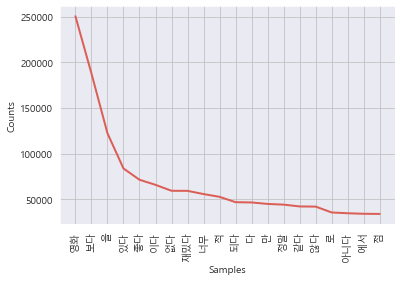

In [38]:
text.plot(20)
plt.show()

In [39]:
text.concordance('영화')

Displaying 25 of 250411 matches:
 시간 짜다 리 인데 차다 흡인 력 있다 태어나다 처음 가슴 아리다 영화 이다 년 이상 지나다 생각 또 가슴 아리다 황순원 소나기 에서 또 
느낌 을 받다 되어다 평생 못 잊다 장면 이자 추억 이다 인생 최고 영화 말 필요 없다 감독판 감동 덜하다 아름답다 영화 지금 까지 보다 영
억 이다 인생 최고 영화 말 필요 없다 감독판 감동 덜하다 아름답다 영화 지금 까지 보다 영화 중 끝 까지 감동 적 이다 영화 전율 여운 남
화 말 필요 없다 감독판 감동 덜하다 아름답다 영화 지금 까지 보다 영화 중 끝 까지 감동 적 이다 영화 전율 여운 남다 영화 여지 껏 내 
하다 아름답다 영화 지금 까지 보다 영화 중 끝 까지 감동 적 이다 영화 전율 여운 남다 영화 여지 껏 내 인생 에서 젤 감동 인 영화 영화
금 까지 보다 영화 중 끝 까지 감동 적 이다 영화 전율 여운 남다 영화 여지 껏 내 인생 에서 젤 감동 인 영화 영화음악 거장 엔 리오 모
이다 영화 전율 여운 남다 영화 여지 껏 내 인생 에서 젤 감동 인 영화 영화음악 거장 엔 리오 모 리꼬 네 까지 완벽하다 내 죽 을 때 까
때 까지 이렇다 명작 나오다 힘들다 같다 너무 아름답다 감동 적 인 영화 내 인생 최고 영화 아직 까지 영화 보다 때 감동 을 잊다 수 없다
 나오다 힘들다 같다 너무 아름답다 감동 적 인 영화 내 인생 최고 영화 아직 까지 영화 보다 때 감동 을 잊다 수 없다 음악 을 들다 자동
같다 너무 아름답다 감동 적 인 영화 내 인생 최고 영화 아직 까지 영화 보다 때 감동 을 잊다 수 없다 음악 을 들다 자동 연상 되다 정말
때 감동 을 잊다 수 없다 음악 을 들다 자동 연상 되다 정말 최고 영화 감수성 을 자극 하고 우리나라 에는 소나기 있다 외국 에는 시네마 
시네마 천국 있다 ㅎㅎ 추억 방울방울 추억 을 먹다 살다 나이 되다 영화 눈물 나다 고맙다 영화 에서 나 향수 느끼다 알 베르토 토토가 함께
추억 방울방울 추억 을 먹다 살다 

# Word Embedding

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [104]:
X_train2 = np.array(X_train.values)
y_train2 = np.array([i[0] for i in y_train])

y_label = np.zeros((len(y_train), len(i2senti.values())))
senti2i = {j : i for i, j in i2senti.items()}
for ix, contents in enumerate(y_train):
    for j in contents:
        if j == ['neutral']:
            continue
        if y_label[ix, senti2i[j]] == 0:
            y_label[ix, senti2i[j]] += 1

In [105]:
ind = np.where(y_label.sum(axis=1) != 0)

In [106]:
X_train2 = X_train2[ind]
y_label = y_label[ind]
y_train2 = y_train2[ind]

In [258]:
tfidf = TfidfVectorizer(tokenizer=tokenizer_morphs, max_features=50000)

In [259]:
%time tfidf_x_train2 = tfidf.fit_transform(X_train2[:500000])

Wall time: 9min 53s


In [260]:
tfidf_x_train2

<500000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 6534033 stored elements in Compressed Sparse Row format>

In [261]:
multi_nbc = MultinomialNB()

In [262]:
y_train2 = list(map(lambda x : senti2i[x], y_train2[:500000]))

In [263]:
multi_nbc.fit(tfidf_x_train2, y_train2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [264]:
tfidf_x_test2 = tfidf.transform(X_train2[500000:])
y_pred = multi_nbc.predict(tfidf_x_test2)

In [273]:
y_test2 = list(map(lambda x : senti2i[x], np.array([i[0] for i in y_train])[ind][500000:]))
accuracy_score(y_test2, y_pred)

0.4900406716028783

In [274]:
from sklearn.metrics import confusion_matrix
confu_mat = confusion_matrix(y_test2, y_pred)
confu_mat

array([[12158,  1280,  2130,  1469,  1559,  2371,  2143,  1650],
       [ 2435,  7369,  2433,  1547,  1477,  1502,  2124,  2156],
       [ 1662,   855, 13237,   865,  1504,  2116,  1615,  3058],
       [ 2087,  1058,  1502, 12284,  1697,  2653,  2004,  2614],
       [ 1542,   944,  1932,  1721, 11057,  2026,  1892,  1403],
       [ 1041,   577,  2000,  1747,  1441, 14917,  1298,  3934],
       [ 2506,  1069,  1967,  1509,  1939,  2260, 11924,  2767],
       [ 1198,   840,  3415,  1457,  1114,  3419,  2166, 15733]],
      dtype=int64)

In [275]:
np.diag(confu_mat) / confu_mat.sum(axis=1)

array([0.49103393, 0.35018771, 0.53135035, 0.47430403, 0.49105121,
       0.55340382, 0.45965846, 0.53619385])

In [276]:
np.mean(np.diag(confu_mat) / confu_mat.sum(axis=1))

0.4858979189340402

In [312]:
multi_nbc.predict_proba(tfidf.transform(['페르소나 시스템은 최고인 것 같아요! 100점 주고 갑니다~']))

array([[0.13114162, 0.09154253, 0.03787647, 0.15387261, 0.13675126,
        0.16109405, 0.20892399, 0.07879747]])

In [313]:
multi_nbc.predict_proba(tfidf.transform(['이 영화는 정말 신선하다... 너무나도 재밌다!']))

array([[0.04603095, 0.06286324, 0.11563741, 0.11443958, 0.11193337,
        0.17436677, 0.05865495, 0.31607373]])

In [345]:
multi_nbc.predict_proba(tfidf.transform([
            spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', '페르소나 시스템은 최고인 것 같아요!'))
        ]))

array([[0.19490732, 0.12450266, 0.06790178, 0.1975888 , 0.10725298,
        0.07130679, 0.15693122, 0.07960845]])

In [347]:
multi_nbc.predict_proba(tfidf.transform([
            spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', '100점 주고 갑니다~'))
        ]))

array([[0.09601815, 0.09813447, 0.04214745, 0.0624022 , 0.12025563,
        0.27506293, 0.22990579, 0.07607337]])

In [349]:
multi_nbc.predict_proba(tfidf.transform([
            spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', '100점 드립니다~'))
        ]))

array([[0.20732505, 0.05743455, 0.03294537, 0.05468339, 0.11200088,
        0.4004785 , 0.07731742, 0.05781485]])

In [350]:
multi_nbc.predict_proba(tfidf.transform([
            spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', '100점 입니다~'))
        ]))

array([[0.07439045, 0.08521373, 0.05819612, 0.17249993, 0.25838263,
        0.1875699 , 0.08084412, 0.08290311]])

In [351]:
import seaborn as sns
sns.set_style('whitegrid')

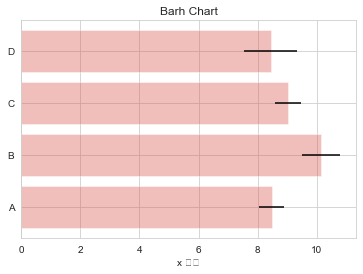

In [357]:
np.random.seed(0)

people = ['A', 'B', 'C', 'D']
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

plt.title("Barh Chart")
plt.barh(y_pos, performance, xerr=error, alpha=0.4)
plt.yticks(y_pos, people)
plt.xlabel('x 라벨')
plt.show()

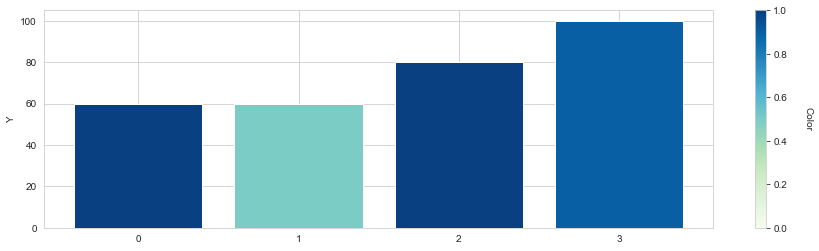

In [390]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

data_x = [0,1,2,3]
data_hight = [60,60,80,100]
data_color = [1000.,500.,1000.,900.]


data_color = [x / max(data_color) for x in data_color]
fig, ax = plt.subplots(figsize=(15, 4))

my_cmap = plt.cm.get_cmap('GnBu')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Color', rotation=270,labelpad=25)

plt.xticks(data_x)    
plt.ylabel("Y")

plt.show()

In [445]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler((1, 8))
minmax.fit_transform(
    np.array([0.20732505, 0.05743455, 0.03294537, 0.05468339, 0.11200088, 0.4004785 , 0.07731742, 0.05781485]).reshape(-1, 1)
)

array([[4.32121831],
       [1.46641852],
       [1.        ],
       [1.4140202 ],
       [2.5056835 ],
       [8.        ],
       [1.84510572],
       [1.47366168]])

In [452]:
colors

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [457]:
colors

array([[0.78431373, 0.28431373, 0.        , 1.        ],
       [1.        , 0.67647059, 0.17647059, 1.        ],
       [0.39215686, 0.        , 0.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.56862745, 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [1.        , 1.        , 0.96078431, 1.        ]])

In [464]:
np.argsort(np.argsort(d))

array([6, 2, 0, 1, 5, 7, 4, 3], dtype=int64)

In [485]:
np.argsort(np.argsort(d))[::-1] * 50

array([150, 200, 350, 250,  50,   0, 100, 300], dtype=int64)

In [486]:
my_cmap = plt.cm.get_cmap('YlOrRd')

In [487]:
my_cmap(data_color)

array([[0.50196078, 0.        , 0.14901961, 1.        ],
       [0.99554018, 0.6781238 , 0.28942714, 1.        ],
       [1.        , 1.        , 0.8       , 1.        ],
       [0.99777009, 0.88481353, 0.53379469, 1.        ],
       [0.53948481, 0.        , 0.14901961, 1.        ],
       [0.50196078, 0.        , 0.14901961, 1.        ],
       [0.84928874, 0.07397155, 0.12056901, 1.        ],
       [0.9893887 , 0.37854671, 0.18546713, 1.        ]])

In [557]:
data_color

array([ 60,  80, 140, 100,  20,   0,  40, 120], dtype=int64)

In [573]:
d

array([[0.20732505, 0.05743455, 0.03294537, 0.05468339, 0.11200088,
        0.4004785 , 0.07731742, 0.05781485]])

In [590]:
[7 - i for i in [6, 2, 0, 1, 5, 7, 4, 3]]

[1, 5, 7, 6, 2, 0, 3, 4]

In [604]:
d[0][np.argsort(d[0])]

array([0.03294537, 0.05468339, 0.05743455, 0.05781485, 0.07731742,
       0.11200088, 0.20732505, 0.4004785 ])

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]], dtype=int64)

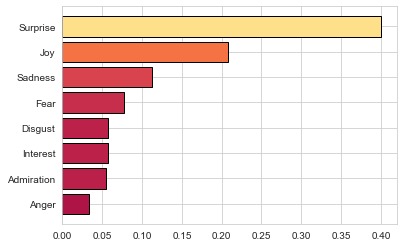

In [606]:
d = np.array([[0.20732505, 0.05743455, 0.03294537, 0.05468339, 0.11200088,
        0.4004785 , 0.07731742, 0.05781485]])

data_color = d[0][np.argsort(d[0])]
my_cmap = plt.cm.get_cmap('Spectral')
colors = my_cmap(data_color)

plt.barh(np.arange(8), d[0][np.argsort(d[0])], color=colors, edgecolor='k')
plt.yticks(np.arange(8), np.array(['Joy', 'Interest', 'Anger', 'Admiration', 'Sadness', 'Surprise', 'Fear', 'Disgust'])[np.argsort(d[0])])
plt.show()

In [664]:
def plot_res(text, o=True, cmap='Spectral'):
    if o:
        t = tfidf.transform([spacer.space(re.sub('[ㄱ-ㅎㅏ-ㅣ가힣]', ' ', text))])
    else:
        t = tfidf.transform([text])
    d = multi_nbc.predict_proba(t)
    print(d)
    data_color = d[0][np.argsort(d[0])]
    my_cmap = plt.cm.get_cmap(cmap)
    colors = my_cmap(data_color)

    plt.barh(np.arange(8), d[0][np.argsort(d[0])], color=colors, edgecolor='k')
    plt.yticks(np.arange(8), np.array(['Joy', 'Interest', 'Anger', 'Admiration', 'Sadness', 'Surprise', 'Fear', 'Disgust'])[np.argsort(d[0])])
    plt.show()

[[0.09928364 0.34036112 0.03788022 0.10446269 0.19943853 0.04887706
  0.12965829 0.04003845]]


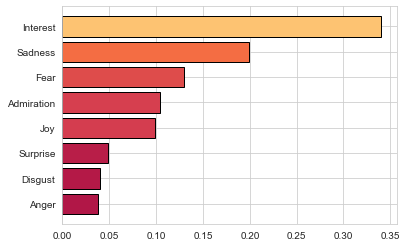

In [685]:
plot_res('이건 진짜 길이 길이 남겨서 봐야 할 영화다. 언제 또 이 동굴을 볼 수 있을텐가. 우리 시대에 이것을 볼 수 있는 건 행운이다.')

In [ ]:
'진짜 너무 재미있다 ㅜㅜ스토리가 조금 유치한데 특유의 풋풋함이랑 피아노 선율로 커버 한다 ㅜㅜ'

무슨 말이 더 필요하나? 최고다! 연출가 배우들은 이 드라마 시즌 제 끝가지 책임져라. 당신 들을 평생 응원하겠다!
[[0.07983849 0.04527888 0.03512903 0.51041711 0.06135573 0.11297336
  0.10654275 0.04846466]]


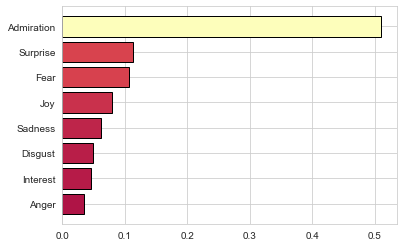

In [663]:
text = input()
plot_res(text, o=True)

무슨 말이 더 필요하나? 최고다! 연출가 배우들은 이 드라마 시즌 제 끝가지 책임져라. 당신 들을 평생 응원하겠다!
[[0.08391538 0.04013053 0.03566444 0.49643034 0.05044359 0.08002521
  0.16490866 0.04848185]]


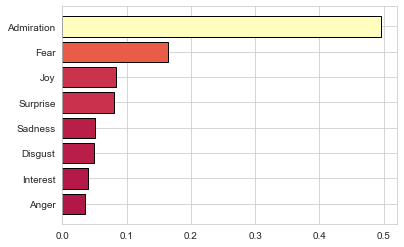

In [662]:
text = input()
plot_res(text, o=False)

In [686]:
tt = np.array(list(map(lambda x : spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x)), X_train2[500000::20])))

In [688]:
tt2 = tfidf.transform(tt)

In [786]:
a = np.array(list(map(lambda x : i2senti[x], multi_nbc.predict_proba(tt2).argmax(axis=1))))[multi_nbc.predict_proba(tt2).max(axis=1) > .3]

In [792]:
X_train2[500000::20][multi_nbc.predict_proba(tt2).max(axis=1) > .3][np.where(a == 'anger')[0]]

array(['돌아오지 말았어야;', '최악... 지루함의 극치는 둘째쳐, 대체 이렇게 잡스러운 영화는 또 뭐니?',
       '뻔한 결과에.. 진부한 내용.. 잼없네요', '볼만은 하지만 평점은 좀 그러네요',
       '괜찮은데 막판에 어설픈 전개가 걸리네',
       '주인공이 열라 양아치네.. 팔라딘 쪽은 세계의 질서라는 명분이라도 있지 뭐 영화로 써는 그냥 볼만은 함',
       '소재도 참신하고 그걸 또 잘 표현했다. 방이라는 한정된 공간에서 일어날 수 있는 일들은 다 한듯. 근데 이게 호러라는 타이틀을 달고 나오기에는 조금.. 호러나 가족애나 둘 중 하나만 취해줬음 좋겠다. 덕분에 스케일 큰 비급영화 같은 느낌.',
       '뜻은 있으나 1408호에서 일어나는 일들이 공포스럽지 않고 너무 과잉된 느낌 좀 더 공포스러운 맛을 더 살렸으면 더 좋았을듯',
       '소재도, 줄거디도, 유쾌한 분위기도 다 우디 앨런 답다',
       '특별한 감동도 재미도 그럭저럭이다. 근데 진짜 한국 제목을 어찌 저 따위로 ㅡㅡ;;',
       '재밋지만 그래 픽이 별로 이고 좀 그렇다 ㅋ', '훌륭하진 않지만 독특하긴 하다. 천정명 영화중 그나마 젤 낫다.',
       '어쩌다 가끔 웃기긴 하다.... 코미디물보단 액션쪽에 더 비중을 많이 뒀으면 더 흥행하지 않았을까 한다... 배우들 연기와 액션이 너무 좋았는데..',
       '시도는 좋았지만 결국 영화는 일반적인 틀을 벗어나 버리면 뭔가 지루해지기 마련. 미드 24를 영화화 한 느낌도 크고 반전이 너무 약함. 배우들의 좋은 연기력에 비해 아류 같은 시나리오 및 연출이 영화를 죽임.',
       '20세기에 나 통했을 방식을 반복하는 영화. 오락 영화로서 리듬감은 괜찮으나 다중시점이란 장치를 비효율적으로 사용하고 있다.',
       '큰 기대를 하고 본다면 실망', '윌리암 메이시 에러, 개에러, 존나 에러',
       '지루하고 졸리네요 별 내용 없는 실화 잘 좀

[[0.06716652 0.08149605 0.4638988  0.03358412 0.04224396 0.0298481
  0.0653974  0.21636505]]


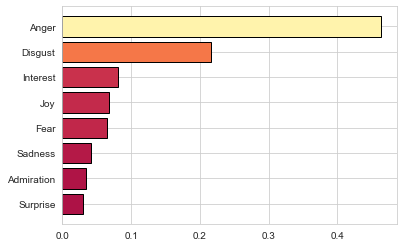

In [794]:
text = '차라리 귀신 코드로 갔음 좋았을걸... 피부에 모가 나면 병원을 가야지. 어울리지 않게 왠 시답잖은 바이러스 좀비모드냐..'
plot_res(text)

[[0.02774903 0.05069559 0.12310682 0.04345243 0.02787725 0.17444291
  0.05984921 0.49282676]]


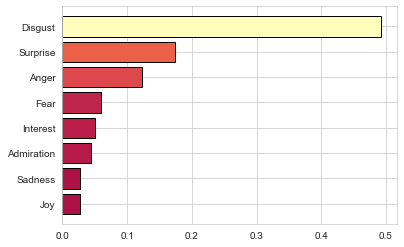

In [753]:
text = '서운 장면 안 나온다면서 엄청 나왔 완전 ㅡㅡ 낚였네 그래도 무서웠다'
plot_res(text)

[[0.09752233 0.07867832 0.45203959 0.04442681 0.10325476 0.05411421
  0.06767879 0.1022852 ]]


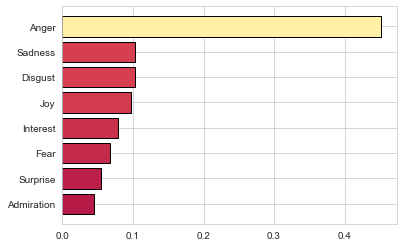

In [727]:
text = '난 역시 프랑스와 맞지 않아...'
plot_res(text)

[[0.46923529 0.07259648 0.24253472 0.02140808 0.09647159 0.01354461
  0.05466756 0.02954167]]


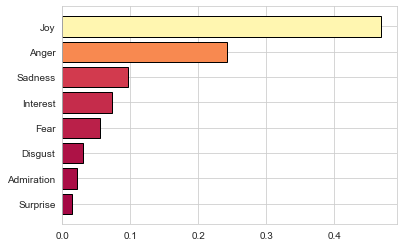

In [724]:
text = '그저 유럽 특유의 거침없는 표현 방식만 마음에 든다.'
plot_res(text)

[[0.31204898 0.06056302 0.43818826 0.01552754 0.0869941  0.01185939
  0.04328824 0.03153047]]


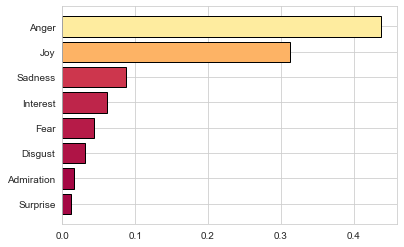

In [722]:
text = '난 역시 프랑스와 맞지 않아... 그저 유럽 특유의 거침없는 표현 방식만 마음에 든다.'
plot_res(text)

In [777]:
a = [119208, 411527, 575334, 95526, 17351, 137675, 637004, 638779, 46602, 447256, 404467, 146225, 31242, 32103]
tester = df[['author', 'review']].loc[a]

In [778]:
ttester = np.array(list(map(lambda x : spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x)), tester['review'])))
ttester = tfidf.transform(ttester)

In [779]:
a2 = np.array(list(map(lambda x : i2senti[x], multi_nbc.predict_proba(ttester).argmax(axis=1))))[multi_nbc.predict_proba(ttester).max(axis=1) > .3]

In [780]:
print(tester['review'].values)

['재미게봤다 전작을안봐서잘모르지만스토리보다배드신위주로보는데이건전부다봤다 스토리도b급영화치고탄탄하고밑에놈들이랑다르게여주매력있게생겻다이쁜여잔아닌데매력있었다.. 그리고중간중간 가슴골이보이는거같은은꼴재밌게봤다 1편도한번봐봐야겟다'
 '지츠니 오모시로이!' '조혼나 재밌었다 조혼나'
 '진짜다잘하고재밌는데근데짜리몽땅은약간가수가아니라합창이더어울리는거같다만약쟤네가우승한다면가수로서할수잇는장르를어떤걸해야할지발라드랩힙합댄스;;가수는아닌듯진짜잘하긴하는데가수는아닌거같다약가알멩이나버나드박이가수로서가능성재능이잇는듯'
 '전 이거 볼빠엔 차라리 트랜스포머4를 보겠어요'
 '영화 배급사 ㅅㄲ들 진짜 제목낚시 불법화 못하나? 원제는 빅풋인데 왜 아무 상관 없는 혹성탈출 이름을 쓰냐? 진짜 영화에 대한 명예훼손이다.'
 '뻔하고 지루했어요... 하지만 엄마는 위대하다!'
 '여자주인공 섭외잘못한듯..너무나 갸냘프고 여리여리해서영화캐릭에 안어울림 . 영화에 집중이 안됨..좀더 카리스마있는여배우였으면 좋았을텐데..'
 '너무재밓었다그래서보는것을추천한다' '동성애 예찬 영화? 천재의 고뇌? 도대체 무엇을 말하고 싶은 건지 알 수 없는 영화.'
 '좀 아쉬웠지만 귀는 심심하지 않았다.' '이거 생각지도 않은 수작이다 무협의 재미를 충분히 만끽하는 작품'
 '어렸을때 봤는데 야한장면 나올때 낯뜨거웠음.'
 '영화를보는동안미스터리하면서도 가슴이미어지는 영화였다 "이 사람들 이상해"라고 하는 남주인공이 알게 모르게 와 닿았다 사람이 그사람들을 평가하고 동물들을 죽이네 살리네 하는 인간의 기준이 뭔가 그게 타당 한가에 대해서 의구심이 들었고 한편으로 안타깝다']


In [781]:
pd.DataFrame(multi_nbc.predict_proba(ttester))

,0,1,2,3,4,5,6,7
0,0.055861,0.052890,0.105537,0.052643,0.046000,0.159240,0.094476,0.433353
1,0.069941,0.075019,0.088768,0.355199,0.095990,0.083389,0.134973,0.096720
2,0.105594,0.106174,0.120680,0.105165,0.066460,0.142494,0.082011,0.271423
3,0.079735,0.081185,0.140315,0.183541,0.104967,0.174346,0.119373,0.116538
4,0.050127,0.173807,0.119533,0.076702,0.083882,0.143405,0.168999,0.183546
5,0.033574,0.047433,0.349525,0.050752,0.138094,0.080781,0.166625,0.133216
6,0.318844,0.086863,0.185215,0.090558,0.032034,0.044943,0.101750,0.139793
7,0.202555,0.047871,0.137787,0.071217,0.036350,0.290300,0.051099,0.162821
8,0.139452,0.075142,0.074123,0.111239,0.195129,0.079651,0.240836,0.084429
9,0.156382,0.097483,0.208747,0.036893,0.120022,0.013380,0.351102,0.015990


[[0.1394519  0.07514165 0.07412313 0.11123859 0.19512874 0.07965062
  0.24083622 0.08442915]]


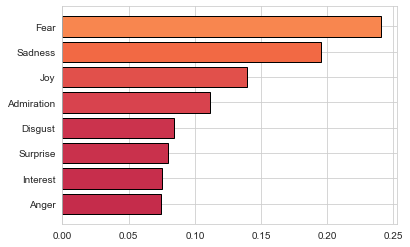

In [783]:
plot_res('너무재밓었다그래서보는것을추천한다')

[[0.10343472 0.06949504 0.07377597 0.10904288 0.14375878 0.11839547
  0.21868533 0.16341181]]


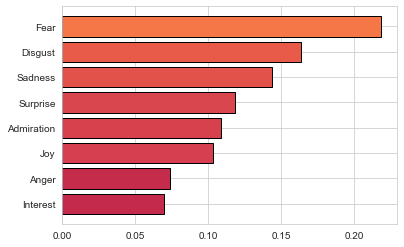

In [784]:
plot_res('너무재밌었다그래서보는것을추천한다')

In [567]:
np.argsort(np.argsort(d[0]))[::-1]

array([1, 5, 2, 6, 4, 0, 7, 3], dtype=int64)

In [339]:
for i, text in enumerate(X_train2[500000:]):
    if i % 1000 == 0:
        print(text)
        pred_proba = multi_nbc.predict_proba(tfidf.transform([
            spacer.space(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', text))
        ]))
        print(pred_proba)
        print(i2senti[np.argmax(pred_proba)], end='\n\n')

그야말로 명랑한 영화. 너무 명랑해 허무맹랑하지만서도
[[0.04698039 0.12455549 0.1895203  0.08408932 0.18520765 0.09607903
  0.09070898 0.18285884]]
anger

플롯이 좋은 영화 스토리 마저 좋다
[[0.16744559 0.12152061 0.26422549 0.08694278 0.08959018 0.11730422
  0.04397675 0.10899439]]
anger

ㅎㅎㅎ 아이부터 어른들까지... 감동도 있고 재미도 있고... 저한테는 최고의 애니중 하나입니다.
[[0.02701495 0.03919796 0.03267524 0.6473016  0.07284602 0.0577072
  0.04263166 0.08062537]]
admiration

기대하고 봐도 됨 매니악적인 영화 절이 싫으면 중이 떠나면 되는 영화
[[0.06718787 0.07270482 0.16554085 0.06509797 0.12636881 0.16605634
  0.17107519 0.16596816]]
fear

사람들이 무슨 예술을 바라고 이 영화를 보고 이러는지 몰라도 재밌다
[[0.1496457  0.10739787 0.09713157 0.10017721 0.14309086 0.10667564
  0.19857442 0.09730672]]
fear

두 번의 반전이 나름 재미있었다는...
[[0.07307384 0.17443425 0.17451013 0.08107262 0.05065881 0.08790996
  0.10240922 0.25593117]]
disgust

조제의 치즈루보다 훨씬 현실적으로 다가오는..
[[0.28811115 0.18143028 0.09293029 0.05722823 0.16135746 0.08533474
  0.05392488 0.07968298]]
joy

정상인 남자가 장애인 여자 하나를 못이겨서 답답했다고? 니들도 싸이코 패스한테 칼빵 먼저 맞아주고 싸워봐.. 

  0.08915542 0.11154378]]
sadness

좀 유치하긴 해도 나름대로 즐거운 시간.
[[0.04855058 0.03286215 0.45072191 0.03671009 0.07509732 0.0782946
  0.05095179 0.22681156]]
anger

지금 반정도 보고 온 건데.. 우와. 난 맷데이먼 파격적이였어...ㅋ
[[0.02998462 0.07544866 0.04654725 0.1313849  0.06108913 0.38686697
  0.13769051 0.13098796]]
surprise

댄스적인 부분만 좋았어요. 재미는 상당히! 중간...
[[0.14381211 0.14604145 0.12821298 0.21633619 0.10314689 0.09131788
  0.03200335 0.13912915]]
admiration

꺄울~ 히히 재밌었어요 ^^ 드라마 평점은 이게 처음 매기는 거네용~ ^^ 히히
[[0.09439024 0.08094379 0.07250543 0.10387347 0.09672089 0.2507793
  0.1027882  0.19799868]]
surprise

역대 최고의 영화가 맞다.
[[0.04386362 0.0370021  0.12998865 0.43333358 0.15127079 0.09273664
  0.05192907 0.05987554]]
admiration

평점 조절 위원회
[[0.0711567  0.01132331 0.03027399 0.0099045  0.0147738  0.83774885
  0.01536483 0.00945401]]
surprise

헐리우드도 이런 우뢰 매수준의 영화를 만드는구나....
[[0.03307402 0.03682506 0.1577249  0.04290789 0.35905814 0.2542406
  0.064976   0.0511934 ]]
sadness

배우들 연기도 좋았고, 시나리오는 더 좋았다~!! !
[[0.34560774 0.04

In [277]:
multi_nbc.predict_proba(tfidf_x_test2)

array([[0.04780901, 0.12504455, 0.19027386, ..., 0.0956226 , 0.09046518,
        0.17950313],
       [0.09514178, 0.10149355, 0.15567953, ..., 0.12292308, 0.12602824,
        0.10454898],
       [0.0427852 , 0.05092161, 0.22764152, ..., 0.25013094, 0.10642353,
        0.15597543],
       ...,
       [0.07415571, 0.09426427, 0.0327974 , ..., 0.13998284, 0.06516975,
        0.05942608],
       [0.12023208, 0.07544589, 0.06525182, ..., 0.14625793, 0.10552349,
        0.12231406],
       [0.10597045, 0.17823673, 0.01162535, ..., 0.05438305, 0.03661051,
        0.07157405]])

In [156]:
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)

In [157]:
sgd_clf.fit(tfidf_x_train2[:500000], y_train2[:500000])

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [158]:
y_pred = sgd_clf.predict(tfidf_x_train2[500000:])

In [159]:
accuracy_score(y_train2[500000:], y_pred)

0.4930600042707666

In [160]:
confu_mat = confusion_matrix(y_train2[500000:], y_pred)

In [163]:
print(confu_mat)
print(np.diag(confu_mat) / confu_mat.sum(axis=1))
print(np.mean(np.diag(confu_mat) / confu_mat.sum(axis=1)))

[[12870  1503  1252  2325  2367  1598  1422  1423]
 [ 2149  8409  1445  2269  2086  1404  1473  1808]
 [ 1920  1388 10501  1865  2772  2088  1485  2893]
 [ 1652  1167   907 15186  2019  1542  1214  2212]
 [ 1113  1015   907  1685 14291  1353   990  1163]
 [ 1562   981  1363  2836  2215 12926  1160  3912]
 [ 2461  1714  1720  2615  3148  2013  9634  2636]
 [ 1500  1293  2331  2466  2024  2609  1649 15470]]
[0.51978998 0.39961032 0.42152376 0.58635469 0.63467602 0.47953997
 0.37138121 0.52723059]
0.4925133191859465


In [172]:
i2senti[
    sgd_clf.predict(tfidf.transform(['페르소나 시스템은 최고인 것 같아요! 100점 주고 갑니다~']))[0]
]

'admiration'

# Word Embedding: doc2vec

In [191]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

y_train2 = np.array([i[0] for i in y_train])[ind]

tagged_docs = [TaggedDocument(d, c) for d, c in zip(processed_reviews, y_train2)]

In [192]:
tagged_train_docs = tagged_docs[:500000]
tagged_test_docs = tagged_docs[500000:]

In [193]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [194]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [195]:
from gensim.models import doc2vec
print(doc2vec.FAST_VERSION)

1


In [196]:
from gensim.models.doc2vec import Doc2Vec

In [197]:
doc_vectorizer = Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=8,        # distance between the predicted word and context words
    vector_size=300,        # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=20,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=cores,   # multi cpu
    hs = 1,          # hierarchical softmax / default 0
    negative = 10,   # negative sampling / default 5
)

In [199]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

2019-11-10 17:31:41,644 : INFO : collecting all words and their counts
2019-11-10 17:31:41,646 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-11-10 17:31:41,818 : INFO : PROGRESS: at example #10000, processed 121751 words (707200/s), 10584 word types, 16 tags
2019-11-10 17:31:41,971 : INFO : PROGRESS: at example #20000, processed 236379 words (756493/s), 15122 word types, 16 tags
2019-11-10 17:31:42,124 : INFO : PROGRESS: at example #30000, processed 357958 words (801392/s), 18546 word types, 16 tags
2019-11-10 17:31:42,275 : INFO : PROGRESS: at example #40000, processed 480368 words (806316/s), 21627 word types, 16 tags
2019-11-10 17:31:42,431 : INFO : PROGRESS: at example #50000, processed 602200 words (786811/s), 24123 word types, 16 tags
2019-11-10 17:31:42,601 : INFO : PROGRESS: at example #60000, processed 724755 words (721148/s), 26393 word types, 16 tags
2019-11-10 17:31:42,763 : INFO : PROGRESS: at example #70000, processed 841551 words (7

Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t8)


In [200]:
doc_vectorizer.corpus_count

500000

In [202]:
doc_vectorizer.epochs

5

In [203]:
%%time
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

2019-11-10 17:37:15,859 : INFO : training model with 8 workers on 11328 vocabulary and 300 features, using sg=1 hs=1 sample=0.001 negative=10 window=8
2019-11-10 17:37:16,979 : INFO : EPOCH 1 - PROGRESS: at 0.15% examples, 12323 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:37:18,186 : INFO : EPOCH 1 - PROGRESS: at 1.50% examples, 54574 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:37:19,401 : INFO : EPOCH 1 - PROGRESS: at 2.82% examples, 67198 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:37:20,511 : INFO : EPOCH 1 - PROGRESS: at 4.23% examples, 75826 words/s, in_qsize 16, out_qsize 1
2019-11-10 17:37:21,618 : INFO : EPOCH 1 - PROGRESS: at 5.54% examples, 80428 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:37:22,862 : INFO : EPOCH 1 - PROGRESS: at 6.88% examples, 82116 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:37:24,114 : INFO : EPOCH 1 - PROGRESS: at 8.16% examples, 82811 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:37:25,317 : INFO : EPOCH 1 - PROGRESS: at 9.42% exa

2019-11-10 17:38:43,550 : INFO : EPOCH 1 - PROGRESS: at 94.14% examples, 82954 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:38:44,719 : INFO : EPOCH 1 - PROGRESS: at 95.40% examples, 82892 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:38:45,798 : INFO : EPOCH 1 - PROGRESS: at 96.55% examples, 82876 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:38:46,855 : INFO : EPOCH 1 - PROGRESS: at 97.53% examples, 82722 words/s, in_qsize 13, out_qsize 0
2019-11-10 17:38:47,701 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 17:38:47,795 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 17:38:47,906 : INFO : EPOCH 1 - PROGRESS: at 98.94% examples, 82925 words/s, in_qsize 5, out_qsize 1
2019-11-10 17:38:47,909 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 17:38:48,088 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 17:38:48,134 : INFO : worker thread finished; awaiting finish

2019-11-10 17:40:02,716 : INFO : EPOCH 2 - PROGRESS: at 73.61% examples, 77114 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:40:03,751 : INFO : EPOCH 2 - PROGRESS: at 74.87% examples, 77254 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:40:04,766 : INFO : EPOCH 2 - PROGRESS: at 75.88% examples, 77205 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:40:06,057 : INFO : EPOCH 2 - PROGRESS: at 77.39% examples, 77314 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:40:07,106 : INFO : EPOCH 2 - PROGRESS: at 78.87% examples, 77644 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:40:08,217 : INFO : EPOCH 2 - PROGRESS: at 79.93% examples, 77518 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:40:09,294 : INFO : EPOCH 2 - PROGRESS: at 81.20% examples, 77615 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:40:10,431 : INFO : EPOCH 2 - PROGRESS: at 82.33% examples, 77605 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:40:11,442 : INFO : EPOCH 2 - PROGRESS: at 83.50% examples, 77723 words/s, in_qsize

2019-11-10 17:41:24,722 : INFO : EPOCH 3 - PROGRESS: at 54.63% examples, 75030 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:41:25,857 : INFO : EPOCH 3 - PROGRESS: at 55.63% examples, 74853 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:27,080 : INFO : EPOCH 3 - PROGRESS: at 57.12% examples, 75109 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:41:28,206 : INFO : EPOCH 3 - PROGRESS: at 58.65% examples, 75491 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:29,288 : INFO : EPOCH 3 - PROGRESS: at 59.74% examples, 75433 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:30,379 : INFO : EPOCH 3 - PROGRESS: at 60.78% examples, 75322 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:31,506 : INFO : EPOCH 3 - PROGRESS: at 62.07% examples, 75438 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:32,515 : INFO : EPOCH 3 - PROGRESS: at 63.16% examples, 75453 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:41:33,528 : INFO : EPOCH 3 - PROGRESS: at 64.24% examples, 75467 words/s, in_qsize

2019-11-10 17:42:49,079 : INFO : EPOCH 4 - PROGRESS: at 36.90% examples, 70797 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:42:50,486 : INFO : EPOCH 4 - PROGRESS: at 38.59% examples, 71317 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:42:51,878 : INFO : EPOCH 4 - PROGRESS: at 40.27% examples, 71808 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:42:53,328 : INFO : EPOCH 4 - PROGRESS: at 41.87% examples, 72128 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:42:54,400 : INFO : EPOCH 4 - PROGRESS: at 43.31% examples, 72723 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:42:55,959 : INFO : EPOCH 4 - PROGRESS: at 45.01% examples, 72923 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:42:57,398 : INFO : EPOCH 4 - PROGRESS: at 46.72% examples, 73281 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:42:58,874 : INFO : EPOCH 4 - PROGRESS: at 48.42% examples, 73546 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:43:00,511 : INFO : EPOCH 4 - PROGRESS: at 50.12% examples, 73575 words/s, in_qsize

2019-11-10 17:44:15,816 : INFO : EPOCH 5 - PROGRESS: at 25.44% examples, 70453 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:17,033 : INFO : EPOCH 5 - PROGRESS: at 26.57% examples, 70787 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:18,052 : INFO : EPOCH 5 - PROGRESS: at 27.49% examples, 71065 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:19,558 : INFO : EPOCH 5 - PROGRESS: at 28.78% examples, 71114 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:20,646 : INFO : EPOCH 5 - PROGRESS: at 30.04% examples, 71779 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:21,661 : INFO : EPOCH 5 - PROGRESS: at 30.60% examples, 70987 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:23,073 : INFO : EPOCH 5 - PROGRESS: at 32.11% examples, 71427 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:44:24,486 : INFO : EPOCH 5 - PROGRESS: at 33.79% examples, 71973 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:44:25,561 : INFO : EPOCH 5 - PROGRESS: at 35.21% examples, 72671 words/s, in_qsize

2019-11-10 17:45:32,471 : INFO : EPOCH 1 - PROGRESS: at 6.86% examples, 64799 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:33,924 : INFO : EPOCH 1 - PROGRESS: at 8.16% examples, 66287 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:35,528 : INFO : EPOCH 1 - PROGRESS: at 9.46% examples, 66610 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:36,985 : INFO : EPOCH 1 - PROGRESS: at 10.74% examples, 67595 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:45:38,381 : INFO : EPOCH 1 - PROGRESS: at 12.08% examples, 68704 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:45:39,852 : INFO : EPOCH 1 - PROGRESS: at 13.42% examples, 69321 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:41,407 : INFO : EPOCH 1 - PROGRESS: at 14.78% examples, 69580 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:42,907 : INFO : EPOCH 1 - PROGRESS: at 16.01% examples, 69761 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:45:44,285 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 70374 words/s, in_qsize 16

2019-11-10 17:47:06,578 : INFO : EPOCH 2 - PROGRESS: at 2.82% examples, 55377 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:47:08,164 : INFO : EPOCH 2 - PROGRESS: at 4.21% examples, 59901 words/s, in_qsize 16, out_qsize 1
2019-11-10 17:47:09,710 : INFO : EPOCH 2 - PROGRESS: at 5.53% examples, 62289 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:47:11,196 : INFO : EPOCH 2 - PROGRESS: at 6.86% examples, 64419 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:47:12,645 : INFO : EPOCH 2 - PROGRESS: at 8.16% examples, 65974 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:47:14,214 : INFO : EPOCH 2 - PROGRESS: at 9.46% examples, 66527 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:47:15,683 : INFO : EPOCH 2 - PROGRESS: at 10.74% examples, 67453 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:47:17,066 : INFO : EPOCH 2 - PROGRESS: at 12.08% examples, 68638 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:47:18,456 : INFO : EPOCH 2 - PROGRESS: at 13.42% examples, 69611 words/s, in_qsize 15, o

2019-11-10 17:48:40,391 : INFO : EPOCH 2 - PROGRESS: at 98.57% examples, 77521 words/s, in_qsize 7, out_qsize 1
2019-11-10 17:48:40,395 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 17:48:40,848 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 17:48:41,046 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 17:48:41,186 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 17:48:41,340 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-10 17:48:41,418 : INFO : EPOCH 2 - PROGRESS: at 99.56% examples, 77458 words/s, in_qsize 2, out_qsize 1
2019-11-10 17:48:41,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-10 17:48:41,421 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-10 17:48:41,488 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-10 17:48:41,490 : INFO : EPOCH - 2 : tra

2019-11-10 17:50:01,047 : INFO : EPOCH 3 - PROGRESS: at 79.93% examples, 77830 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:02,600 : INFO : EPOCH 3 - PROGRESS: at 81.55% examples, 77813 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:50:04,107 : INFO : EPOCH 3 - PROGRESS: at 83.12% examples, 77826 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:05,512 : INFO : EPOCH 3 - PROGRESS: at 84.70% examples, 77944 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:06,931 : INFO : EPOCH 3 - PROGRESS: at 86.23% examples, 78013 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:50:08,468 : INFO : EPOCH 3 - PROGRESS: at 87.74% examples, 77973 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:09,893 : INFO : EPOCH 3 - PROGRESS: at 89.20% examples, 78005 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:11,288 : INFO : EPOCH 3 - PROGRESS: at 90.74% examples, 78103 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:50:12,718 : INFO : EPOCH 3 - PROGRESS: at 92.25% examples, 78151 words/s, in_qsize

2019-11-10 17:51:31,627 : INFO : EPOCH 4 - PROGRESS: at 72.31% examples, 77845 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:51:32,969 : INFO : EPOCH 4 - PROGRESS: at 74.03% examples, 78098 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:51:34,452 : INFO : EPOCH 4 - PROGRESS: at 75.67% examples, 78155 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:51:35,931 : INFO : EPOCH 4 - PROGRESS: at 77.39% examples, 78253 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:51:37,286 : INFO : EPOCH 4 - PROGRESS: at 79.11% examples, 78476 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:51:38,636 : INFO : EPOCH 4 - PROGRESS: at 80.79% examples, 78662 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:51:39,794 : INFO : EPOCH 4 - PROGRESS: at 82.10% examples, 78796 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:51:41,124 : INFO : EPOCH 4 - PROGRESS: at 83.31% examples, 78610 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:51:42,255 : INFO : EPOCH 4 - PROGRESS: at 84.70% examples, 78795 words/s, in_qsize

2019-11-10 17:52:52,373 : INFO : EPOCH 5 - PROGRESS: at 53.46% examples, 76006 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:52:53,847 : INFO : EPOCH 5 - PROGRESS: at 55.02% examples, 76108 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:52:55,430 : INFO : EPOCH 5 - PROGRESS: at 56.72% examples, 76146 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:52:56,784 : INFO : EPOCH 5 - PROGRESS: at 58.42% examples, 76455 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:52:58,133 : INFO : EPOCH 5 - PROGRESS: at 60.19% examples, 76804 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:52:59,643 : INFO : EPOCH 5 - PROGRESS: at 61.83% examples, 76883 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:53:01,209 : INFO : EPOCH 5 - PROGRESS: at 63.61% examples, 76941 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:53:02,597 : INFO : EPOCH 5 - PROGRESS: at 65.26% examples, 77156 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:53:03,927 : INFO : EPOCH 5 - PROGRESS: at 66.98% examples, 77451 words/s, in_qsize

2019-11-10 17:54:11,264 : INFO : EPOCH 1 - PROGRESS: at 31.75% examples, 71265 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:12,668 : INFO : EPOCH 1 - PROGRESS: at 33.39% examples, 71808 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:14,126 : INFO : EPOCH 1 - PROGRESS: at 35.02% examples, 72206 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:15,670 : INFO : EPOCH 1 - PROGRESS: at 36.67% examples, 72434 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:17,130 : INFO : EPOCH 1 - PROGRESS: at 38.37% examples, 72834 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:18,525 : INFO : EPOCH 1 - PROGRESS: at 40.06% examples, 73300 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:19,986 : INFO : EPOCH 1 - PROGRESS: at 41.67% examples, 73575 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:21,554 : INFO : EPOCH 1 - PROGRESS: at 43.31% examples, 73695 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:54:22,964 : INFO : EPOCH 1 - PROGRESS: at 45.01% examples, 74091 words/s, in_qsize

2019-11-10 17:55:40,431 : INFO : EPOCH 2 - PROGRESS: at 24.07% examples, 71193 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:55:41,792 : INFO : EPOCH 2 - PROGRESS: at 25.28% examples, 71528 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:55:43,206 : INFO : EPOCH 2 - PROGRESS: at 26.57% examples, 71807 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:55:44,845 : INFO : EPOCH 2 - PROGRESS: at 27.82% examples, 71536 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:55:46,328 : INFO : EPOCH 2 - PROGRESS: at 29.16% examples, 71664 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:55:47,739 : INFO : EPOCH 2 - PROGRESS: at 30.60% examples, 72066 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:55:49,208 : INFO : EPOCH 2 - PROGRESS: at 32.11% examples, 72361 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:55:50,824 : INFO : EPOCH 2 - PROGRESS: at 33.79% examples, 72502 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:55:52,198 : INFO : EPOCH 2 - PROGRESS: at 35.44% examples, 73042 words/s, in_qsize

2019-11-10 17:57:04,753 : INFO : EPOCH 3 - PROGRESS: at 13.42% examples, 70241 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:06,149 : INFO : EPOCH 3 - PROGRESS: at 14.78% examples, 71064 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:07,589 : INFO : EPOCH 3 - PROGRESS: at 16.01% examples, 71358 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:08,607 : INFO : EPOCH 3 - PROGRESS: at 16.95% examples, 71794 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:09,747 : INFO : EPOCH 3 - PROGRESS: at 17.73% examples, 71079 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:11,156 : INFO : EPOCH 3 - PROGRESS: at 19.01% examples, 71472 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:12,603 : INFO : EPOCH 3 - PROGRESS: at 20.22% examples, 71623 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:13,604 : INFO : EPOCH 3 - PROGRESS: at 21.29% examples, 72507 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:57:14,632 : INFO : EPOCH 3 - PROGRESS: at 21.75% examples, 71209 words/s, in_qsize

2019-11-10 17:58:25,955 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-10 17:58:26,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-10 17:58:26,266 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-10 17:58:26,267 : INFO : EPOCH - 3 : training on 5276767 raw words (7709313 effective words) took 97.5s, 79045 effective words/s
2019-11-10 17:58:27,754 : INFO : EPOCH 4 - PROGRESS: at 0.18% examples, 9988 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:58:29,155 : INFO : EPOCH 4 - PROGRESS: at 1.50% examples, 43850 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:58:30,537 : INFO : EPOCH 4 - PROGRESS: at 2.82% examples, 55537 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:58:32,090 : INFO : EPOCH 4 - PROGRESS: at 4.23% examples, 60463 words/s, in_qsize 16, out_qsize 0
2019-11-10 17:58:33,564 : INFO : EPOCH 4 - PROGRESS: at 5.54% examples, 63394 words/s, in_qsize 15, out_qsize 0
2019-11-10 17:58:35,024 : INFO 

2019-11-10 18:00:00,774 : INFO : EPOCH 4 - PROGRESS: at 90.53% examples, 74035 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:01,826 : INFO : EPOCH 4 - PROGRESS: at 91.50% examples, 73988 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:00:02,865 : INFO : EPOCH 4 - PROGRESS: at 92.41% examples, 73935 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:03,932 : INFO : EPOCH 4 - PROGRESS: at 93.74% examples, 74173 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:05,295 : INFO : EPOCH 4 - PROGRESS: at 95.19% examples, 74224 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:06,348 : INFO : EPOCH 4 - PROGRESS: at 96.33% examples, 74318 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:07,445 : INFO : EPOCH 4 - PROGRESS: at 97.14% examples, 74102 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:00:08,527 : INFO : EPOCH 4 - PROGRESS: at 98.55% examples, 74347 words/s, in_qsize 8, out_qsize 0
2019-11-10 18:00:08,708 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-1

2019-11-10 18:01:23,938 : INFO : EPOCH 5 - PROGRESS: at 70.69% examples, 74068 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:01:25,490 : INFO : EPOCH 5 - PROGRESS: at 72.31% examples, 74144 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:01:27,017 : INFO : EPOCH 5 - PROGRESS: at 74.03% examples, 74273 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:01:28,679 : INFO : EPOCH 5 - PROGRESS: at 75.67% examples, 74227 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:01:30,084 : INFO : EPOCH 5 - PROGRESS: at 77.39% examples, 74463 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:01:31,539 : INFO : EPOCH 5 - PROGRESS: at 79.11% examples, 74648 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:01:33,133 : INFO : EPOCH 5 - PROGRESS: at 80.77% examples, 74664 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:01:34,691 : INFO : EPOCH 5 - PROGRESS: at 82.33% examples, 74685 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:01:36,110 : INFO : EPOCH 5 - PROGRESS: at 83.94% examples, 74842 words/s, in_qsize

2019-11-10 18:02:47,496 : INFO : EPOCH 1 - PROGRESS: at 50.51% examples, 72309 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:48,747 : INFO : EPOCH 1 - PROGRESS: at 52.00% examples, 72603 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:49,867 : INFO : EPOCH 1 - PROGRESS: at 53.23% examples, 72758 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:50,898 : INFO : EPOCH 1 - PROGRESS: at 54.06% examples, 72521 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:52,129 : INFO : EPOCH 1 - PROGRESS: at 55.43% examples, 72754 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:53,314 : INFO : EPOCH 1 - PROGRESS: at 56.94% examples, 73106 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:02:54,451 : INFO : EPOCH 1 - PROGRESS: at 58.22% examples, 73236 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:02:55,499 : INFO : EPOCH 1 - PROGRESS: at 59.05% examples, 72984 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:02:56,521 : INFO : EPOCH 1 - PROGRESS: at 60.38% examples, 73274 words/s, in_qsize

2019-11-10 18:04:10,903 : INFO : EPOCH 2 - PROGRESS: at 29.88% examples, 68016 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:04:12,207 : INFO : EPOCH 2 - PROGRESS: at 31.15% examples, 68338 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:04:13,228 : INFO : EPOCH 2 - PROGRESS: at 32.11% examples, 68440 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:04:14,333 : INFO : EPOCH 2 - PROGRESS: at 33.39% examples, 68854 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:04:15,357 : INFO : EPOCH 2 - PROGRESS: at 34.39% examples, 68961 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:04:16,459 : INFO : EPOCH 2 - PROGRESS: at 35.86% examples, 69692 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:04:17,772 : INFO : EPOCH 2 - PROGRESS: at 37.10% examples, 69691 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:04:18,896 : INFO : EPOCH 2 - PROGRESS: at 38.16% examples, 69646 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:04:20,125 : INFO : EPOCH 2 - PROGRESS: at 39.41% examples, 69767 words/s, in_qsize

2019-11-10 18:05:35,966 : INFO : EPOCH 3 - PROGRESS: at 16.01% examples, 67140 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:05:37,375 : INFO : EPOCH 3 - PROGRESS: at 17.30% examples, 67802 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:05:38,875 : INFO : EPOCH 3 - PROGRESS: at 18.55% examples, 68084 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:05:40,415 : INFO : EPOCH 3 - PROGRESS: at 19.77% examples, 68170 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:05:41,838 : INFO : EPOCH 3 - PROGRESS: at 20.98% examples, 68546 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:05:42,842 : INFO : EPOCH 3 - PROGRESS: at 22.10% examples, 69572 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:05:43,884 : INFO : EPOCH 3 - PROGRESS: at 22.42% examples, 67973 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:05:44,893 : INFO : EPOCH 3 - PROGRESS: at 23.47% examples, 68851 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:05:45,967 : INFO : EPOCH 3 - PROGRESS: at 24.22% examples, 68586 words/s, in_qsize

2019-11-10 18:06:59,232 : INFO : EPOCH 4 - PROGRESS: at 0.17% examples, 10134 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:07:00,829 : INFO : EPOCH 4 - PROGRESS: at 1.48% examples, 41862 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:07:02,403 : INFO : EPOCH 4 - PROGRESS: at 2.82% examples, 51752 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:07:03,888 : INFO : EPOCH 4 - PROGRESS: at 4.21% examples, 57955 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:07:05,354 : INFO : EPOCH 4 - PROGRESS: at 5.53% examples, 61329 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:07:07,075 : INFO : EPOCH 4 - PROGRESS: at 6.87% examples, 61983 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:07:08,675 : INFO : EPOCH 4 - PROGRESS: at 8.16% examples, 62925 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:07:10,179 : INFO : EPOCH 4 - PROGRESS: at 9.46% examples, 64184 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:07:11,667 : INFO : EPOCH 4 - PROGRESS: at 10.77% examples, 65290 words/s, in_qsize 15, out

2019-11-10 18:08:34,302 : INFO : EPOCH 4 - PROGRESS: at 93.38% examples, 74800 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:08:35,994 : INFO : EPOCH 4 - PROGRESS: at 94.56% examples, 74415 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:08:37,590 : INFO : EPOCH 4 - PROGRESS: at 96.16% examples, 74422 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:08:39,157 : INFO : EPOCH 4 - PROGRESS: at 97.72% examples, 74433 words/s, in_qsize 12, out_qsize 0
2019-11-10 18:08:39,842 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 18:08:39,967 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 18:08:40,044 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 18:08:40,072 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 18:08:40,584 : INFO : EPOCH 4 - PROGRESS: at 99.36% examples, 74577 words/s, in_qsize 3, out_qsize 1
2019-11-10 18:08:40,586 : INFO : worker thread finished; awaiting finish

2019-11-10 18:10:08,000 : INFO : EPOCH 5 - PROGRESS: at 77.15% examples, 68639 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:09,153 : INFO : EPOCH 5 - PROGRESS: at 78.44% examples, 68789 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:10,161 : INFO : EPOCH 5 - PROGRESS: at 79.31% examples, 68704 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:10:11,671 : INFO : EPOCH 5 - PROGRESS: at 81.00% examples, 68898 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:12,712 : INFO : EPOCH 5 - PROGRESS: at 82.33% examples, 69233 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:13,765 : INFO : EPOCH 5 - PROGRESS: at 83.73% examples, 69573 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:14,834 : INFO : EPOCH 5 - PROGRESS: at 84.70% examples, 69567 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:16,051 : INFO : EPOCH 5 - PROGRESS: at 85.67% examples, 69452 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:10:17,106 : INFO : EPOCH 5 - PROGRESS: at 86.97% examples, 69735 words/s, in_qsize

2019-11-10 18:11:35,737 : INFO : EPOCH 1 - PROGRESS: at 65.49% examples, 76925 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:37,364 : INFO : EPOCH 1 - PROGRESS: at 67.17% examples, 76874 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:38,768 : INFO : EPOCH 1 - PROGRESS: at 68.79% examples, 77058 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:11:40,169 : INFO : EPOCH 1 - PROGRESS: at 70.48% examples, 77263 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:41,720 : INFO : EPOCH 1 - PROGRESS: at 72.11% examples, 77281 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:43,215 : INFO : EPOCH 1 - PROGRESS: at 73.82% examples, 77380 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:44,610 : INFO : EPOCH 1 - PROGRESS: at 75.46% examples, 77540 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:11:45,962 : INFO : EPOCH 1 - PROGRESS: at 77.15% examples, 77766 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:11:47,501 : INFO : EPOCH 1 - PROGRESS: at 78.87% examples, 77811 words/s, in_qsize

2019-11-10 18:13:09,743 : INFO : EPOCH 2 - PROGRESS: at 60.58% examples, 75864 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:11,124 : INFO : EPOCH 2 - PROGRESS: at 62.28% examples, 76150 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:13:12,610 : INFO : EPOCH 2 - PROGRESS: at 64.04% examples, 76315 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:14,099 : INFO : EPOCH 2 - PROGRESS: at 65.68% examples, 76416 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:13:15,493 : INFO : EPOCH 2 - PROGRESS: at 67.37% examples, 76642 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:16,818 : INFO : EPOCH 2 - PROGRESS: at 69.03% examples, 76926 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:17,908 : INFO : EPOCH 2 - PROGRESS: at 70.48% examples, 77249 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:19,165 : INFO : EPOCH 2 - PROGRESS: at 71.73% examples, 77176 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:13:20,614 : INFO : EPOCH 2 - PROGRESS: at 73.39% examples, 77313 words/s, in_qsize

2019-11-10 18:14:41,830 : INFO : EPOCH 3 - PROGRESS: at 53.46% examples, 75085 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:14:42,923 : INFO : EPOCH 3 - PROGRESS: at 54.63% examples, 75201 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:14:44,021 : INFO : EPOCH 3 - PROGRESS: at 55.63% examples, 75067 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:14:45,043 : INFO : EPOCH 3 - PROGRESS: at 57.12% examples, 75569 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:14:46,060 : INFO : EPOCH 3 - PROGRESS: at 58.22% examples, 75579 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:14:47,086 : INFO : EPOCH 3 - PROGRESS: at 59.52% examples, 75825 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:14:48,311 : INFO : EPOCH 3 - PROGRESS: at 60.78% examples, 75798 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:14:49,752 : INFO : EPOCH 3 - PROGRESS: at 62.48% examples, 76001 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:14:50,815 : INFO : EPOCH 3 - PROGRESS: at 63.64% examples, 75986 words/s, in_qsize

2019-11-10 18:16:11,388 : INFO : EPOCH 4 - PROGRESS: at 43.76% examples, 74055 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:16:12,751 : INFO : EPOCH 4 - PROGRESS: at 45.45% examples, 74506 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:16:14,284 : INFO : EPOCH 4 - PROGRESS: at 47.14% examples, 74669 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:16:15,869 : INFO : EPOCH 4 - PROGRESS: at 48.88% examples, 74756 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:16:17,274 : INFO : EPOCH 4 - PROGRESS: at 50.51% examples, 75029 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:16:18,692 : INFO : EPOCH 4 - PROGRESS: at 52.20% examples, 75317 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:16:20,266 : INFO : EPOCH 4 - PROGRESS: at 53.86% examples, 75367 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:16:21,775 : INFO : EPOCH 4 - PROGRESS: at 55.43% examples, 75444 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:16:23,120 : INFO : EPOCH 4 - PROGRESS: at 57.12% examples, 75784 words/s, in_qsize

2019-11-10 18:17:39,864 : INFO : EPOCH 5 - PROGRESS: at 32.76% examples, 71301 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:17:41,398 : INFO : EPOCH 5 - PROGRESS: at 34.39% examples, 71581 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:17:42,780 : INFO : EPOCH 5 - PROGRESS: at 36.08% examples, 72158 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:17:43,794 : INFO : EPOCH 5 - PROGRESS: at 37.52% examples, 72935 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:17:44,953 : INFO : EPOCH 5 - PROGRESS: at 38.59% examples, 72758 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:17:46,029 : INFO : EPOCH 5 - PROGRESS: at 39.84% examples, 73041 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:17:47,204 : INFO : EPOCH 5 - PROGRESS: at 41.06% examples, 73151 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:17:48,253 : INFO : EPOCH 5 - PROGRESS: at 42.49% examples, 73760 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:17:49,303 : INFO : EPOCH 5 - PROGRESS: at 43.55% examples, 73750 words/s, in_qsize

2019-11-10 18:18:57,232 : INFO : EPOCH 1 - PROGRESS: at 14.44% examples, 67748 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:18:58,399 : INFO : EPOCH 1 - PROGRESS: at 15.40% examples, 67939 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:18:59,640 : INFO : EPOCH 1 - PROGRESS: at 16.47% examples, 68383 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:19:00,713 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 68168 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:19:01,991 : INFO : EPOCH 1 - PROGRESS: at 18.20% examples, 67858 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:19:03,030 : INFO : EPOCH 1 - PROGRESS: at 19.14% examples, 68297 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:19:04,091 : INFO : EPOCH 1 - PROGRESS: at 20.22% examples, 69180 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:19:05,260 : INFO : EPOCH 1 - PROGRESS: at 21.29% examples, 69674 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:19:06,553 : INFO : EPOCH 1 - PROGRESS: at 21.91% examples, 68365 words/s, in_qsize

2019-11-10 18:20:19,826 : INFO : EPOCH 2 - PROGRESS: at 0.15% examples, 9442 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:20:21,328 : INFO : EPOCH 2 - PROGRESS: at 1.48% examples, 42662 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:20:22,717 : INFO : EPOCH 2 - PROGRESS: at 2.82% examples, 54665 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:20:24,147 : INFO : EPOCH 2 - PROGRESS: at 4.21% examples, 60961 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:20:25,681 : INFO : EPOCH 2 - PROGRESS: at 5.54% examples, 63343 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:20:27,271 : INFO : EPOCH 2 - PROGRESS: at 6.88% examples, 64582 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:20:28,667 : INFO : EPOCH 2 - PROGRESS: at 8.16% examples, 66385 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:20:30,112 : INFO : EPOCH 2 - PROGRESS: at 9.42% examples, 67500 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:20:31,676 : INFO : EPOCH 2 - PROGRESS: at 10.77% examples, 67983 words/s, in_qsize 15, out_

2019-11-10 18:21:54,451 : INFO : EPOCH 2 - PROGRESS: at 97.13% examples, 78036 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:21:55,513 : INFO : EPOCH 2 - PROGRESS: at 98.55% examples, 78269 words/s, in_qsize 8, out_qsize 0
2019-11-10 18:21:55,700 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 18:21:55,911 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 18:21:55,955 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 18:21:55,973 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 18:21:55,993 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-10 18:21:56,155 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-10 18:21:56,159 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-10 18:21:56,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-10 18:21:56,251 : INFO : EPOCH - 2 : tr

2019-11-10 18:23:18,581 : INFO : EPOCH 3 - PROGRESS: at 82.88% examples, 77895 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:23:19,991 : INFO : EPOCH 3 - PROGRESS: at 84.50% examples, 78020 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:23:21,575 : INFO : EPOCH 3 - PROGRESS: at 86.04% examples, 77950 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:23:23,189 : INFO : EPOCH 3 - PROGRESS: at 87.54% examples, 77830 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:23:24,581 : INFO : EPOCH 3 - PROGRESS: at 89.03% examples, 77908 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:23:26,010 : INFO : EPOCH 3 - PROGRESS: at 90.53% examples, 77959 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:23:27,610 : INFO : EPOCH 3 - PROGRESS: at 92.05% examples, 77868 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:23:29,193 : INFO : EPOCH 3 - PROGRESS: at 93.54% examples, 77789 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:23:30,604 : INFO : EPOCH 3 - PROGRESS: at 95.19% examples, 77906 words/s, in_qsize

2019-11-10 18:24:44,339 : INFO : EPOCH 4 - PROGRESS: at 68.60% examples, 76809 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:45,520 : INFO : EPOCH 4 - PROGRESS: at 69.88% examples, 76825 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:46,546 : INFO : EPOCH 4 - PROGRESS: at 71.30% examples, 77205 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:47,581 : INFO : EPOCH 4 - PROGRESS: at 72.31% examples, 77144 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:48,663 : INFO : EPOCH 4 - PROGRESS: at 73.39% examples, 77066 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:49,940 : INFO : EPOCH 4 - PROGRESS: at 74.87% examples, 77165 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:24:50,950 : INFO : EPOCH 4 - PROGRESS: at 76.32% examples, 77534 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:24:52,037 : INFO : EPOCH 4 - PROGRESS: at 77.59% examples, 77633 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:24:53,195 : INFO : EPOCH 4 - PROGRESS: at 78.64% examples, 77456 words/s, in_qsize

2019-11-10 18:26:03,462 : INFO : EPOCH 5 - PROGRESS: at 46.29% examples, 73734 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:04,591 : INFO : EPOCH 5 - PROGRESS: at 47.57% examples, 73901 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:05,671 : INFO : EPOCH 5 - PROGRESS: at 49.10% examples, 74440 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:06,709 : INFO : EPOCH 5 - PROGRESS: at 50.12% examples, 74392 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:08,037 : INFO : EPOCH 5 - PROGRESS: at 51.34% examples, 74239 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:09,110 : INFO : EPOCH 5 - PROGRESS: at 52.61% examples, 74440 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:10,133 : INFO : EPOCH 5 - PROGRESS: at 53.87% examples, 74712 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:26:11,298 : INFO : EPOCH 5 - PROGRESS: at 55.24% examples, 74992 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:26:12,317 : INFO : EPOCH 5 - PROGRESS: at 56.26% examples, 74967 words/s, in_qsize

2019-11-10 18:27:23,894 : INFO : EPOCH 1 - PROGRESS: at 26.57% examples, 70233 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:27:25,343 : INFO : EPOCH 1 - PROGRESS: at 27.82% examples, 70437 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:27:26,820 : INFO : EPOCH 1 - PROGRESS: at 29.16% examples, 70626 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:27:28,398 : INFO : EPOCH 1 - PROGRESS: at 30.59% examples, 70721 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:27:29,938 : INFO : EPOCH 1 - PROGRESS: at 32.11% examples, 70949 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:27:31,363 : INFO : EPOCH 1 - PROGRESS: at 33.79% examples, 71487 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:27:32,699 : INFO : EPOCH 1 - PROGRESS: at 35.44% examples, 72125 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:27:34,249 : INFO : EPOCH 1 - PROGRESS: at 37.10% examples, 72367 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:27:35,760 : INFO : EPOCH 1 - PROGRESS: at 38.79% examples, 72652 words/s, in_qsize

2019-11-10 18:28:56,108 : INFO : EPOCH 2 - PROGRESS: at 21.65% examples, 69125 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:28:57,720 : INFO : EPOCH 2 - PROGRESS: at 22.88% examples, 69050 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:28:59,242 : INFO : EPOCH 2 - PROGRESS: at 24.07% examples, 69066 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:29:00,727 : INFO : EPOCH 2 - PROGRESS: at 25.28% examples, 69208 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:29:02,259 : INFO : EPOCH 2 - PROGRESS: at 26.57% examples, 69327 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:29:03,632 : INFO : EPOCH 2 - PROGRESS: at 27.82% examples, 69722 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:29:05,032 : INFO : EPOCH 2 - PROGRESS: at 29.16% examples, 70090 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:29:06,587 : INFO : EPOCH 2 - PROGRESS: at 30.60% examples, 70262 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:29:08,122 : INFO : EPOCH 2 - PROGRESS: at 32.11% examples, 70503 words/s, in_qsize

2019-11-10 18:30:15,884 : INFO : EPOCH 3 - PROGRESS: at 2.82% examples, 54445 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:30:17,434 : INFO : EPOCH 3 - PROGRESS: at 4.21% examples, 59510 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:18,788 : INFO : EPOCH 3 - PROGRESS: at 5.54% examples, 63678 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:20,281 : INFO : EPOCH 3 - PROGRESS: at 6.86% examples, 65490 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:21,810 : INFO : EPOCH 3 - PROGRESS: at 8.16% examples, 66400 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:23,302 : INFO : EPOCH 3 - PROGRESS: at 9.42% examples, 67236 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:24,681 : INFO : EPOCH 3 - PROGRESS: at 10.74% examples, 68641 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:30:26,236 : INFO : EPOCH 3 - PROGRESS: at 12.08% examples, 68919 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:30:27,750 : INFO : EPOCH 3 - PROGRESS: at 13.42% examples, 69339 words/s, in_qsize 15, o

2019-11-10 18:31:49,715 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-10 18:31:49,783 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-10 18:31:49,968 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-10 18:31:50,082 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-10 18:31:50,083 : INFO : EPOCH - 3 : training on 5276767 raw words (7709477 effective words) took 98.6s, 78227 effective words/s
2019-11-10 18:31:51,461 : INFO : EPOCH 4 - PROGRESS: at 0.15% examples, 10016 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:31:52,848 : INFO : EPOCH 4 - PROGRESS: at 1.50% examples, 45995 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:31:54,378 : INFO : EPOCH 4 - PROGRESS: at 2.82% examples, 55432 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:31:55,875 : INFO : EPOCH 4 - PROGRESS: at 4.23% examples, 60928 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:31:57,302 : INFO : EPOCH 4 - PROGRESS

2019-11-10 18:33:23,765 : INFO : EPOCH 4 - PROGRESS: at 93.93% examples, 77499 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:33:24,936 : INFO : EPOCH 4 - PROGRESS: at 95.40% examples, 77668 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:33:26,031 : INFO : EPOCH 4 - PROGRESS: at 96.75% examples, 77851 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:33:27,177 : INFO : EPOCH 4 - PROGRESS: at 97.53% examples, 77540 words/s, in_qsize 13, out_qsize 0
2019-11-10 18:33:28,285 : INFO : EPOCH 4 - PROGRESS: at 98.57% examples, 77451 words/s, in_qsize 7, out_qsize 1
2019-11-10 18:33:28,291 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 18:33:28,329 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 18:33:28,534 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 18:33:28,612 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 18:33:28,639 : INFO : worker thread finished; awaiting finish

2019-11-10 18:34:54,204 : INFO : EPOCH 5 - PROGRESS: at 84.70% examples, 76672 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:34:55,804 : INFO : EPOCH 5 - PROGRESS: at 86.21% examples, 76601 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:34:57,279 : INFO : EPOCH 5 - PROGRESS: at 87.74% examples, 76641 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:34:58,661 : INFO : EPOCH 5 - PROGRESS: at 89.20% examples, 76731 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:35:00,192 : INFO : EPOCH 5 - PROGRESS: at 90.74% examples, 76732 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:35:01,806 : INFO : EPOCH 5 - PROGRESS: at 92.25% examples, 76649 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:35:03,198 : INFO : EPOCH 5 - PROGRESS: at 93.74% examples, 76746 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:35:04,543 : INFO : EPOCH 5 - PROGRESS: at 95.40% examples, 76934 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:35:06,167 : INFO : EPOCH 5 - PROGRESS: at 96.95% examples, 76857 words/s, in_qsize

2019-11-10 18:36:14,812 : INFO : EPOCH 1 - PROGRESS: at 64.85% examples, 76315 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:36:15,874 : INFO : EPOCH 1 - PROGRESS: at 66.13% examples, 76482 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:36:17,060 : INFO : EPOCH 1 - PROGRESS: at 67.37% examples, 76477 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:36:18,203 : INFO : EPOCH 1 - PROGRESS: at 68.79% examples, 76737 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:36:19,262 : INFO : EPOCH 1 - PROGRESS: at 69.88% examples, 76682 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:36:20,270 : INFO : EPOCH 1 - PROGRESS: at 70.90% examples, 76668 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:36:21,484 : INFO : EPOCH 1 - PROGRESS: at 72.31% examples, 76835 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:36:22,592 : INFO : EPOCH 1 - PROGRESS: at 73.83% examples, 77149 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:36:23,950 : INFO : EPOCH 1 - PROGRESS: at 75.06% examples, 76950 words/s, in_qsize

2019-11-10 18:37:32,445 : INFO : EPOCH 2 - PROGRESS: at 40.24% examples, 72167 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:37:33,504 : INFO : EPOCH 2 - PROGRESS: at 40.85% examples, 71503 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:37:34,939 : INFO : EPOCH 2 - PROGRESS: at 42.49% examples, 71882 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:37:36,445 : INFO : EPOCH 2 - PROGRESS: at 44.12% examples, 72145 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:37:37,989 : INFO : EPOCH 2 - PROGRESS: at 45.88% examples, 72409 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:37:39,416 : INFO : EPOCH 2 - PROGRESS: at 47.57% examples, 72762 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:37:40,819 : INFO : EPOCH 2 - PROGRESS: at 49.30% examples, 73159 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:37:42,396 : INFO : EPOCH 2 - PROGRESS: at 50.91% examples, 73221 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:37:43,888 : INFO : EPOCH 2 - PROGRESS: at 52.58% examples, 73434 words/s, in_qsize

2019-11-10 18:39:02,026 : INFO : EPOCH 3 - PROGRESS: at 29.16% examples, 69354 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:39:03,634 : INFO : EPOCH 3 - PROGRESS: at 30.60% examples, 69458 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:39:05,381 : INFO : EPOCH 3 - PROGRESS: at 32.11% examples, 69350 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:39:06,930 : INFO : EPOCH 3 - PROGRESS: at 33.79% examples, 69713 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:39:08,307 : INFO : EPOCH 3 - PROGRESS: at 35.44% examples, 70324 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:39:09,756 : INFO : EPOCH 3 - PROGRESS: at 37.10% examples, 70789 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:39:11,306 : INFO : EPOCH 3 - PROGRESS: at 38.79% examples, 71060 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:39:12,723 : INFO : EPOCH 3 - PROGRESS: at 40.44% examples, 71508 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:39:14,164 : INFO : EPOCH 3 - PROGRESS: at 42.07% examples, 71867 words/s, in_qsize

2019-11-10 18:40:26,154 : INFO : EPOCH 4 - PROGRESS: at 17.44% examples, 71463 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:40:27,360 : INFO : EPOCH 4 - PROGRESS: at 18.36% examples, 71223 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:40:28,466 : INFO : EPOCH 4 - PROGRESS: at 19.14% examples, 70717 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:40:29,627 : INFO : EPOCH 4 - PROGRESS: at 20.22% examples, 71231 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:40:30,722 : INFO : EPOCH 4 - PROGRESS: at 21.29% examples, 71856 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:40:31,759 : INFO : EPOCH 4 - PROGRESS: at 21.92% examples, 71109 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:40:33,068 : INFO : EPOCH 4 - PROGRESS: at 22.88% examples, 70747 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:40:34,667 : INFO : EPOCH 4 - PROGRESS: at 24.07% examples, 70488 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:40:36,101 : INFO : EPOCH 4 - PROGRESS: at 25.28% examples, 70685 words/s, in_qsize

2019-11-10 18:41:47,977 : INFO : EPOCH 5 - PROGRESS: at 2.82% examples, 54294 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:41:49,350 : INFO : EPOCH 5 - PROGRESS: at 4.21% examples, 61219 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:41:50,738 : INFO : EPOCH 5 - PROGRESS: at 5.54% examples, 64870 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:41:52,365 : INFO : EPOCH 5 - PROGRESS: at 6.86% examples, 65474 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:41:53,821 : INFO : EPOCH 5 - PROGRESS: at 8.16% examples, 66862 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:41:55,214 : INFO : EPOCH 5 - PROGRESS: at 9.42% examples, 68222 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:41:56,699 : INFO : EPOCH 5 - PROGRESS: at 10.74% examples, 68989 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:41:58,248 : INFO : EPOCH 5 - PROGRESS: at 12.06% examples, 69194 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:41:59,617 : INFO : EPOCH 5 - PROGRESS: at 13.42% examples, 70268 words/s, in_qsize 15, o

2019-11-10 18:43:21,560 : INFO : training on a 26383835 raw words (38543275 effective words) took 493.5s, 78100 effective words/s
2019-11-10 18:43:21,561 : INFO : training model with 8 workers on 11328 vocabulary and 300 features, using sg=1 hs=1 sample=0.001 negative=10 window=8
2019-11-10 18:43:22,971 : INFO : EPOCH 1 - PROGRESS: at 0.17% examples, 10205 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:43:24,398 : INFO : EPOCH 1 - PROGRESS: at 1.48% examples, 44510 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:43:25,936 : INFO : EPOCH 1 - PROGRESS: at 2.82% examples, 54300 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:43:27,415 : INFO : EPOCH 1 - PROGRESS: at 4.23% examples, 60193 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:43:28,816 : INFO : EPOCH 1 - PROGRESS: at 5.53% examples, 63724 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:43:30,289 : INFO : EPOCH 1 - PROGRESS: at 6.88% examples, 65837 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:43:31,851 : INFO : EPOCH 1 - PROG

2019-11-10 18:44:52,284 : INFO : EPOCH 1 - PROGRESS: at 91.29% examples, 77767 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:44:53,637 : INFO : EPOCH 1 - PROGRESS: at 92.41% examples, 77567 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:44:54,652 : INFO : EPOCH 1 - PROGRESS: at 93.35% examples, 77501 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:44:55,700 : INFO : EPOCH 1 - PROGRESS: at 94.55% examples, 77594 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:44:56,748 : INFO : EPOCH 1 - PROGRESS: at 95.95% examples, 77832 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:44:57,990 : INFO : EPOCH 1 - PROGRESS: at 97.14% examples, 77751 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:44:59,016 : INFO : EPOCH 1 - PROGRESS: at 98.13% examples, 77698 words/s, in_qsize 10, out_qsize 0
2019-11-10 18:44:59,385 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 18:44:59,586 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 18:44:59,683 : I

2019-11-10 18:46:19,921 : INFO : EPOCH 2 - PROGRESS: at 79.93% examples, 77661 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:46:21,320 : INFO : EPOCH 2 - PROGRESS: at 81.55% examples, 77794 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:22,959 : INFO : EPOCH 2 - PROGRESS: at 83.12% examples, 77681 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:24,428 : INFO : EPOCH 2 - PROGRESS: at 84.70% examples, 77743 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:25,808 : INFO : EPOCH 2 - PROGRESS: at 86.21% examples, 77851 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:27,252 : INFO : EPOCH 2 - PROGRESS: at 87.73% examples, 77889 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:28,731 : INFO : EPOCH 2 - PROGRESS: at 89.20% examples, 77885 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:30,109 : INFO : EPOCH 2 - PROGRESS: at 90.74% examples, 77999 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:46:31,459 : INFO : EPOCH 2 - PROGRESS: at 92.25% examples, 78117 words/s, in_qsize

2019-11-10 18:47:48,635 : INFO : EPOCH 3 - PROGRESS: at 68.43% examples, 75769 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:50,038 : INFO : EPOCH 3 - PROGRESS: at 70.08% examples, 75976 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:47:51,077 : INFO : EPOCH 3 - PROGRESS: at 71.30% examples, 76146 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:52,163 : INFO : EPOCH 3 - PROGRESS: at 72.11% examples, 75842 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:53,228 : INFO : EPOCH 3 - PROGRESS: at 73.61% examples, 76208 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:54,504 : INFO : EPOCH 3 - PROGRESS: at 75.06% examples, 76309 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:47:55,505 : INFO : EPOCH 3 - PROGRESS: at 76.54% examples, 76710 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:56,585 : INFO : EPOCH 3 - PROGRESS: at 77.59% examples, 76623 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:47:57,602 : INFO : EPOCH 3 - PROGRESS: at 78.42% examples, 76402 words/s, in_qsize

2019-11-10 18:49:13,628 : INFO : EPOCH 4 - PROGRESS: at 52.20% examples, 74051 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:49:14,643 : INFO : EPOCH 4 - PROGRESS: at 53.46% examples, 74332 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:49:15,722 : INFO : EPOCH 4 - PROGRESS: at 54.26% examples, 73985 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:49:16,952 : INFO : EPOCH 4 - PROGRESS: at 55.63% examples, 74197 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:49:17,961 : INFO : EPOCH 4 - PROGRESS: at 57.12% examples, 74726 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:49:19,077 : INFO : EPOCH 4 - PROGRESS: at 58.42% examples, 74872 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:49:20,134 : INFO : EPOCH 4 - PROGRESS: at 59.74% examples, 75107 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:49:21,266 : INFO : EPOCH 4 - PROGRESS: at 60.78% examples, 74953 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:49:22,287 : INFO : EPOCH 4 - PROGRESS: at 62.07% examples, 75197 words/s, in_qsize

2019-11-10 18:50:37,743 : INFO : EPOCH 5 - PROGRESS: at 35.44% examples, 72004 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:39,346 : INFO : EPOCH 5 - PROGRESS: at 37.12% examples, 72168 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:40,737 : INFO : EPOCH 5 - PROGRESS: at 38.79% examples, 72653 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:42,109 : INFO : EPOCH 5 - PROGRESS: at 40.44% examples, 73133 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:43,599 : INFO : EPOCH 5 - PROGRESS: at 42.07% examples, 73374 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:50:44,612 : INFO : EPOCH 5 - PROGRESS: at 43.55% examples, 74070 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:45,646 : INFO : EPOCH 5 - PROGRESS: at 45.01% examples, 74692 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:46,674 : INFO : EPOCH 5 - PROGRESS: at 45.69% examples, 74108 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:50:47,943 : INFO : EPOCH 5 - PROGRESS: at 47.14% examples, 74349 words/s, in_qsize

2019-11-10 18:51:59,786 : INFO : EPOCH 1 - PROGRESS: at 20.63% examples, 70285 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:00,954 : INFO : EPOCH 1 - PROGRESS: at 21.60% examples, 70287 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:02,002 : INFO : EPOCH 1 - PROGRESS: at 22.59% examples, 70680 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:03,131 : INFO : EPOCH 1 - PROGRESS: at 23.33% examples, 70227 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:52:04,138 : INFO : EPOCH 1 - PROGRESS: at 24.07% examples, 70040 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:05,508 : INFO : EPOCH 1 - PROGRESS: at 25.28% examples, 70400 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:06,597 : INFO : EPOCH 1 - PROGRESS: at 26.40% examples, 71013 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:52:07,629 : INFO : EPOCH 1 - PROGRESS: at 27.18% examples, 70850 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:52:08,648 : INFO : EPOCH 1 - PROGRESS: at 27.82% examples, 70331 words/s, in_qsize

2019-11-10 18:53:16,682 : INFO : EPOCH 2 - PROGRESS: at 1.50% examples, 44469 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:53:18,142 : INFO : EPOCH 2 - PROGRESS: at 2.82% examples, 55105 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:53:19,701 : INFO : EPOCH 2 - PROGRESS: at 4.21% examples, 59944 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:53:21,101 : INFO : EPOCH 2 - PROGRESS: at 5.53% examples, 63582 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:53:22,626 : INFO : EPOCH 2 - PROGRESS: at 6.86% examples, 65229 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:53:24,260 : INFO : EPOCH 2 - PROGRESS: at 8.16% examples, 65516 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:53:25,795 : INFO : EPOCH 2 - PROGRESS: at 9.42% examples, 66222 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:53:27,168 : INFO : EPOCH 2 - PROGRESS: at 10.74% examples, 67748 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:53:28,704 : INFO : EPOCH 2 - PROGRESS: at 12.08% examples, 68197 words/s, in_qsize 15, ou

2019-11-10 18:54:47,529 : INFO : EPOCH 2 - PROGRESS: at 93.74% examples, 77327 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:54:48,900 : INFO : EPOCH 2 - PROGRESS: at 95.40% examples, 77489 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:54:50,451 : INFO : EPOCH 2 - PROGRESS: at 96.95% examples, 77461 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:54:51,969 : INFO : EPOCH 2 - PROGRESS: at 98.55% examples, 77482 words/s, in_qsize 8, out_qsize 0
2019-11-10 18:54:52,151 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-10 18:54:52,162 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-10 18:54:52,269 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-10 18:54:52,271 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-10 18:54:52,354 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-10 18:54:52,356 : INFO : worker thread finished; awaiting finish of 2 more threads
201

2019-11-10 18:56:10,134 : INFO : EPOCH 3 - PROGRESS: at 77.15% examples, 77145 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:11,602 : INFO : EPOCH 3 - PROGRESS: at 78.87% examples, 77270 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:13,135 : INFO : EPOCH 3 - PROGRESS: at 80.56% examples, 77307 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:14,530 : INFO : EPOCH 3 - PROGRESS: at 82.10% examples, 77426 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:56:15,889 : INFO : EPOCH 3 - PROGRESS: at 83.73% examples, 77607 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:16,958 : INFO : EPOCH 3 - PROGRESS: at 85.11% examples, 77848 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:18,075 : INFO : EPOCH 3 - PROGRESS: at 85.67% examples, 77346 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:56:19,319 : INFO : EPOCH 3 - PROGRESS: at 86.97% examples, 77396 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:56:20,662 : INFO : EPOCH 3 - PROGRESS: at 88.47% examples, 77527 words/s, in_qsize

2019-11-10 18:57:34,675 : INFO : EPOCH 4 - PROGRESS: at 61.83% examples, 76505 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:35,727 : INFO : EPOCH 4 - PROGRESS: at 62.71% examples, 76210 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:36,927 : INFO : EPOCH 4 - PROGRESS: at 64.04% examples, 76245 words/s, in_qsize 16, out_qsize 0
2019-11-10 18:57:38,108 : INFO : EPOCH 4 - PROGRESS: at 65.49% examples, 76483 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:39,860 : INFO : EPOCH 4 - PROGRESS: at 67.17% examples, 76304 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:41,267 : INFO : EPOCH 4 - PROGRESS: at 68.79% examples, 76496 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:42,673 : INFO : EPOCH 4 - PROGRESS: at 70.48% examples, 76707 words/s, in_qsize 14, out_qsize 1
2019-11-10 18:57:44,200 : INFO : EPOCH 4 - PROGRESS: at 72.13% examples, 76772 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:57:45,679 : INFO : EPOCH 4 - PROGRESS: at 73.83% examples, 76895 words/s, in_qsize

2019-11-10 18:58:57,784 : INFO : EPOCH 5 - PROGRESS: at 43.94% examples, 73629 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:58:58,915 : INFO : EPOCH 5 - PROGRESS: at 45.45% examples, 74140 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:00,441 : INFO : EPOCH 5 - PROGRESS: at 47.14% examples, 74324 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:02,029 : INFO : EPOCH 5 - PROGRESS: at 48.88% examples, 74420 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:03,412 : INFO : EPOCH 5 - PROGRESS: at 50.51% examples, 74732 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:04,841 : INFO : EPOCH 5 - PROGRESS: at 52.20% examples, 75006 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:06,396 : INFO : EPOCH 5 - PROGRESS: at 53.87% examples, 75097 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:07,951 : INFO : EPOCH 5 - PROGRESS: at 55.43% examples, 75119 words/s, in_qsize 15, out_qsize 0
2019-11-10 18:59:09,442 : INFO : EPOCH 5 - PROGRESS: at 57.12% examples, 75284 words/s, in_qsize

Wall time: 1h 22min 32s


In [204]:
model_name = 'Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model'
doc_vectorizer.save(model_name)

2019-11-10 19:02:08,276 : INFO : saving Doc2Vec object under Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model, separately None
C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-10 19:02:08,938 : INFO : saved Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model


In [205]:
# Load model
doc_vectorizer = Doc2Vec.load(model_name)

2019-11-10 19:02:24,931 : INFO : loading Doc2Vec object from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model
2019-11-10 19:02:25,273 : INFO : loading vocabulary recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model.vocabulary.* with mmap=None
2019-11-10 19:02:25,273 : INFO : loading trainables recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model.trainables.* with mmap=None
2019-11-10 19:02:25,274 : INFO : loading wv recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model.wv.* with mmap=None
2019-11-10 19:02:25,274 : INFO : loading docvecs recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model.docvecs.* with mmap=None
2019-11-10 19:02:25,275 : INFO : loaded Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)191110,1901.model


In [207]:
print(doc_vectorizer.wv.most_similar('영화'))

[('아니다', 0.4557894766330719), ('있다', 0.45251360535621643), ('좋다', 0.4491743743419647), ('그', 0.43568357825279236), ('수', 0.4310079514980316), ('정말', 0.4245113730430603), ('이다', 0.4219512343406677), ('작품', 0.41632887721061707), ('배우', 0.4090302288532257), ('을', 0.40493834018707275)]


In [208]:
print(doc_vectorizer.wv.most_similar('쓰레기'))

[('이딴', 0.5163722038269043), ('ㅡㅡ', 0.4914303421974182), ('최악', 0.49017900228500366), ('거지같다', 0.4672131836414337), ('졸작', 0.4616900086402893), ('ㅉㅉ', 0.4509204626083374), ('아깝다', 0.4476994574069977), ('삼류', 0.44056206941604614), ('죄다', 0.4272134602069855), ('망하다', 0.41897711157798767)]


In [211]:
print(doc_vectorizer.wv.most_similar(positive=['영화', '남자'], negative=['여배우']))

[('사랑', 0.38121578097343445), ('내', 0.35052186250686646), ('그', 0.3500772714614868), ('같다', 0.3461473286151886), ('사람', 0.3452305197715759), ('여자', 0.3398347496986389), ('아버지', 0.32562142610549927), ('아니다', 0.3256176710128784), ('이야기', 0.3170894980430603), ('현실', 0.31571337580680847)]


In [212]:
print(doc_vectorizer.wv.most_similar(positive=['시간', '남자'], negative=['재미']))

[('여자', 0.428205668926239), ('그녀', 0.31777656078338623), ('사랑', 0.31208500266075134), ('집착', 0.30429941415786743), ('주인공', 0.2886381149291992), ('남편', 0.28540879487991333), ('돈', 0.28274041414260864), ('결국', 0.28234341740608215), ('부인', 0.2795960605144501), ('지나가다', 0.2795185446739197)]


# 모델 학습 및 평가하기: doc2vec

In [216]:
X_train_d2v = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
y_train_d2v = [doc.tags for doc in tagged_train_docs]

In [217]:
X_test_d2v = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
y_test_d2v = [doc.tags for doc in tagged_test_docs]

In [218]:
print(len(X_train_d2v), len(y_train_d2v))

500000 500000


In [220]:
X_train_np_d2v = np.asarray(X_train_d2v)
X_test_np_d2v = np.asarray(X_test_d2v)

In [233]:
lbl = LabelEncoder()
y_train_np_d2v = lbl.fit_transform(y_train_d2v)
y_test_np_d2v = lbl.transform(y_test_d2v)

In [234]:
print(len(X_train_np_d2v[0]), len(X_test_np_d2v[0]))

300 300


In [242]:
y_train_np_d2v = np.eye(8)[y_train_np_d2v]
y_test_np_d2v = np.eye(8)[y_test_np_d2v]

# Logistic Regression

In [243]:
from sklearn.linear_model import LogisticRegression

In [246]:
log_clf = LogisticRegression(random_state=42, multi_class='auto', solver='lbfgs')

In [247]:
%time log_clf.fit(X_train_d2v, y_train_d2v)

Wall time: 23.9 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [248]:
y_pred = log_clf.predict(X_test_d2v)

In [253]:
accuracy_score(y_test_d2v, y_pred)

0.13722072414323952

In [103]:
import numpy as np

In [116]:
np.random.normal(loc=52.4, scale=2, size=(40))

array([47.75441349, 51.86373351, 48.73244823, 57.46276859, 52.87997655,
       51.0238669 , 50.92447625, 54.36062588, 49.15320585, 54.87470267,
       51.51144795, 54.85226139, 52.21990128, 51.35814554, 51.32897698,
       50.8510877 , 52.34428551, 55.42113651, 52.88165526, 55.36157338,
       51.83987125, 51.3517866 , 51.94622044, 55.38854741, 49.80074549,
       50.78327332, 53.68312792, 50.58719277, 51.80179642, 49.19547932,
       54.58568543, 50.26761931, 53.34648585, 47.14281114, 52.30175969,
       52.66305668, 51.95135198, 50.37983497, 53.03201082, 54.47083207])

In [254]:
confu_mat = confusion_matrix(y_test_d2v, y_pred)

In [255]:
print(confu_mat)
print(np.diag(confu_mat) / confu_mat.sum(axis=1))
print(np.mean(np.diag(confu_mat) / confu_mat.sum(axis=1)))

[[ 2636   697 14932  1045   307   842   918  4522]
 [ 2581   613 14433   967   315   812   870  4321]
 [ 2954   782 17059  1091   369   981  1062  5044]
 [ 2617   680 15098  1003   335   862   910  4436]
 [ 2222   564 12145   815   239   740   758  3560]
 [ 2442   619 14593   947   275   802   900  4182]
 [ 2311   619 13093   832   295   757   753  3857]
 [ 2743   718 15671  1021   331   965   979  4527]]
[0.10177999 0.02460662 0.58138505 0.03866466 0.0113577  0.03239095
 0.0334414  0.16794658]
0.12394661762418993


In [ ]:
i2senti[
    sgd_clf.predict(tfidf.transform(['페르소나 시스템은 최고인 것 같아요! 100점 주고 갑니다~']))[0]
]

In [63]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t8)


In [65]:
doc_vectorizer.corpus_count

712383

In [66]:
doc_vectorizer.epochs

5

In [ ]:
%%time
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples=doc_vectorizer.corpus_count, 
                         epochs=doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

# 연습장2

In [278]:
path = 'c:/research_persona/sentiment_analysis/movie_review_sentiment'
df = pd.read_csv(path + '/raw_data_nsmc.csv')

In [281]:
df[['author', 'review']].shape

(712383, 2)

In [282]:
a = [119208, 411527, 575334, 95526, 17351, 137675, 637004,
     315357, 75030, 447256, 404467, 146225, 31242, 32103,
     430194, 398209, 638779, 660307, 550639, 243616,
     582840, 46602, 626347]
df[['author', 'review']].loc[a]

,author,review
119208,msle****,재미게봤다 전작을안봐서잘모르지만스토리보다배드신위주로보는데이건전부다봤다 스토리도b급영...
411527,hait****,지츠니 오모시로이!
575334,rude****,조혼나 재밌었다 조혼나
95526,eunb****,진짜다잘하고재밌는데근데짜리몽땅은약간가수가아니라합창이더어울리는거같다만약쟤네가우승한다면...
17351,thdw****,전 이거 볼빠엔 차라리 트랜스포머4를 보겠어요
137675,kkmk****,영화 배급사 ㅅㄲ들 진짜 제목낚시 불법화 못하나? 원제는 빅풋인데 왜 아무 상관 없...
637004,nocg****,뻔하고 지루했어요... 하지만 엄마는 위대하다!
315357,dlwo****,부럽지 않다.
75030,2000****,기대기대우어엉야아이제
447256,kndo****,동성애 예찬 영화? 천재의 고뇌? 도대체 무엇을 말하고 싶은 건지 알 수 없는 영화.


# 띄어쓰기 미리미리 해놓기

In [2]:
from chatspace import ChatSpace

spacer = ChatSpace()

Loading JIT Compiled ChatSpace Model


In [7]:
d_path = 'd:/naver_review/'
review_folder = os.listdir(d_path)
t = {}
for ix, review_file in enumerate(review_folder):
    with open(d_path + review_file, 'rb') as f:
        t[ix] = json.load(f)
t1 = pd.DataFrame.from_dict(t[0])
t2 = pd.DataFrame.from_dict(t[1])
t3 = pd.DataFrame.from_dict(t[2])
t4 = pd.DataFrame.from_dict(t[3])
t5 = pd.DataFrame.from_dict(t[4])
t6 = pd.DataFrame.from_dict(t[5])

dfnew = pd.concat((t1, t2, t3, t4, t5, t6))
del t, t1, t2, t3, t4, t5, t6

In [8]:
dfnew.shape

(2532415, 10)

In [9]:
dfnew = dfnew[['author', 'review', 'point', 'sympathy', 'notsympathy']]

In [10]:
dfnew.index = range(len(dfnew))

In [11]:
re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', dfnew.loc[19, 'review'])

'관람객  인권의 대지로 건너가는 징검다리의 돌 하나같은 영화  북한 인권에 대한 관심이 끊어져서는 안된다  영화 자체로서는 아쉬움이 남았다 '

In [12]:
%time dfnew['review'] = dfnew['review'].map(lambda x : re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x))

Wall time: 15.3 s


In [13]:
dfnew['review'] = dfnew['review'].replace('관람객', '').map(lambda x : x.strip())

In [24]:
%time reviews1 = dfnew['review'][:int(len(dfnew) * .33)].map(lambda x : spacer.space(x))

Wall time: 3h 1min 27s


In [25]:
with open('spacing_reviews1.pkl', 'wb') as f:
    pickle.dump(reviews1, f, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
%time reviews2 = dfnew['review'][int(len(dfnew) * .33):int(len(dfnew) * .66)].map(lambda x : spacer.space(x))

Wall time: 9h 8min 58s


In [27]:
with open('spacing_reviews2.pkl', 'wb') as f:
    pickle.dump(reviews2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
%time reviews3 = dfnew['review'][int(len(dfnew) * .66):].map(lambda x : spacer.space(x))

Wall time: 3h 7min 20s


In [29]:
with open('spacing_reviews3.pkl', 'wb') as f:
    pickle.dump(reviews3, f, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
ksenticnets['연인']['sentic_value']

[0.033, -0.07, 0.0, 0.0]

In [37]:
ksenticnets['싫어하']['sentic_value']

[-0.09, 0.213, 0.596, -0.61]

In [38]:
ksenticnets['안']['sentic_value']

[-0.76, 0.0, 0.869, 0.0]

In [39]:
ksenticnets['재미']['sentic_value']

[0.901, 0.487, -0.193, 0.409]

In [32]:
ksenticnets.keys()

dict_keys(['가게', '가격', '가계', '가곡', '가공', '가교', '가구', '가금', '가난', '가난뱅이', '가난하', '가내', '가담', '가담하', '가도', '가동', '가동하', '가랑비', '가랑이', '가래침', '가로', '가로등', '가로막', '가르치', '가리키', '가마', '가망', '가망없', '가모', '가뭄', '가부', '가부장제', '가빠', '가사', '가상', '가상하', '가설하', '가성', '가세', '가세하', '가속도', '가수', '가슴', '가슴앓이', '가실', '가업', '가옥', '가운데', '가위', '가을', '가이드', '가인', '가장자리', '가장하', '가재', '가재도구', '가정과', '가정의', '가정하', '가제', '가족', '가죽', '가지', '가축', '가치', '가택', '가필', '각본', '각부', '각성', '각성제', '각오', '각오하', '각축', '각하', '각형', '간', '간계', '간과', '간발', '간부', '간사', '간선도로', '간섭', '간섭하', '간세포', '간수', '간음', '간장', '간주하', '간지', '간첩', '간행', '간행물', '간호', '갈', '갈등', '갈림길', '갈매기', '갈보', '갈색', '갈증', '감', '감각', '감각하', '감귤', '감금', '감금하', '감기', '감독', '감리', '감미료', '감별', '감사', '감사하', '감상', '감색', '감수', '감식', '감응', '감자', '감정하', '감지', '감찰', '감청', '감축', '감칠맛', '값', '값어치', '갓난아기', '갓난아이', '갓난애', '강구', '강구하', '강국', '강대국', '강도', '강론', '강모', '강박하', '강습', '강습하', '강심제', '강아지', '강의실', '강장제', '강조', '강조하', '강풍', '강화', '개', '개가', '개가하', '개구리', '개그맨',

In [310]:
%time reviews = dfnew['review'].map(lambda x : spacer.space(x))

Wall time: 3h 6min 53s


In [311]:
len(reviews)

712383

In [ ]:
df2 = df.copy()

In [ ]:
JST = Sentiment

# 돌릴 수 있는 모형 구축

In [45]:
reviews = pd.concat((reviews1, reviews2, reviews3))

In [46]:
with open('spacing_253reviews.pkl', 'wb') as f:
    pickle.dump(reviews, f, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
reviews

0              감동입니다 말이 필요 없습니다 꼭 보세요 그리고 상영관을 늘려 주심 감사하겠습니다
1                                            쩌네요 장관이구요 걸경입니다
2          우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그...
3                  북한의 현실을 보여주는 영화입니다 정말 이런 영화가 많이 배급되어야 합니다
4          많이 울었습니다 화도 나고 속상하고 북한의 현실을 나라 꼭대기에 앉아있는 그 분과 ...
5                                          모든 국민이 다 봐야 되는 영화
6          북한의 실상에 대해 더 절실히 알게 되는 영화였습니다 귀한 영화 만들어 주셔서 감사합니다
7          북한의 실상을 보여주는 가슴 아픈 영화였습니다 하루 빨리 북한에도 진정한 자유가 주...
8                                            이건 꼭 봐야 할 영화입니다
9          현실은 우리를 행동하게 만드다 영화를 보는 내내 정말 현실이지 않기를 바랬던 유일한 영화
10                                    최고의 영화 다들 꼭 봐야 할 영화입니다
11                                           진짜 꼭 봐야 될 영화입니다
12         북한 신봉하는 놈들아 제발 정신 좀 차리길 자본주의에서 누릴 거 다 누려놓고 북한 ...
13                                  자유 민주주의를 위하여 북한의 인권을 위하여
14           적어도 만명 돌파는 가야합니다 상영관 멀어서 못가시는 분들은 좌파들처럼 영혼 보냅시다
15                                          재인이가 이 영화를 싫어합니다
16         실화를 바탕으로 제작한 

# 2019.11.21

In [3]:
import os
import json
import pandas as pd

d_path = 'd:/naver_review/'
review_folder = os.listdir(d_path)
t = {}
for ix, review_file in enumerate(review_folder):
    with open(d_path + review_file, 'rb') as f:
        t[ix] = json.load(f)
t1 = pd.DataFrame.from_dict(t[0])
t2 = pd.DataFrame.from_dict(t[1])
t3 = pd.DataFrame.from_dict(t[2])
t4 = pd.DataFrame.from_dict(t[3])
t5 = pd.DataFrame.from_dict(t[4])
t6 = pd.DataFrame.from_dict(t[5])

dfnew = pd.concat((t1, t2, t3, t4, t5, t6))
del t, t1, t2, t3, t4, t5, t6

In [4]:
dfnew.head()

,MovieName,MovieCode,MovieComeOut,MovieType,ReviewCreateTime,author,point,sympathy,notsympathy,review
0,사랑의 선물,182699,2019.08.15,15세 관람가,2019.09.30 19:03,shin****,10.0,0,0,감동입니다.. 말이 필요 없습니다 꼭 보세요그리고 상영관을 늘려 주심 감사하겠습니다^^
1,사랑의 선물,182699,2019.08.15,15세 관람가,2019.09.30 13:21,하하하(zeto****),1.0,0,0,쩌네요 장관이구요 걸경입니다.
2,사랑의 선물,182699,2019.08.15,15세 관람가,2019.09.30 00:59,푸른뽕나무(salt****),10.0,2,0,"우리민족이 북한이 말하는 지상낙원이 아니라 생지옥, 생감옥에 지금 이시간에도 그곳..."
3,사랑의 선물,182699,2019.08.15,15세 관람가,2019.09.30 00:46,고래(salt****),10.0,1,0,북한의 현실을 보여주는 영화입니다.. 정말 이런 영화가 많이 배급되어야 합니다!
4,사랑의 선물,182699,2019.08.15,15세 관람가,2019.09.30 00:11,나는야딸기엄마(ador****),10.0,2,0,많이 울었습니다..화도나고 속상하고.. 북한의 현실을 나라꼭대기에 앉아있는 그분과 ...


In [4]:
dfnew.tail(6)

,MovieName,MovieCode,MovieComeOut,MovieType,ReviewCreateTime,author,point,sympathy,notsympathy,review
341544,사랑의 선물,28677,판타지미스터리,미국,2003.12.14 00:00,kswo****,10.0,0,0,모 채널에 서 하는거 봤는데 최꼰!!
341545,사랑의 선물,28677,판타지미스터리,미국,2003.12.14 00:00,dond****,9.0,0,0,저도 방금 OCN에서 봤거든요... 감동 ㅠ_ㅠ
341546,사랑의 선물,28677,판타지미스터리,미국,2003.12.14 00:00,alll****,10.0,0,0,오랜만에 좋은 영화 본 것 같은 느낌
341547,사랑의 선물,28677,판타지미스터리,미국,2003.12.13 00:00,ays9****,10.0,0,0,좋은 영화입니다.잘봤습니다..!
341548,사랑의 선물,28677,판타지미스터리,미국,2003.12.08 00:00,tdol****,10.0,0,0,역대 사형수들에 관한 영화 중 가장 재미있었다.
341549,사랑의 선물,28677,판타지미스터리,미국,2003.11.25 00:00,kjin****,7.0,0,0,비처럼 젖어드는 감동


In [5]:
df = pd.read_csv('../sentiment_analysis/movie_review_sentiment/nsmc_data.csv')

In [6]:
df.head(10)

,author,date,movie_id,rating,review,review_id,year,class
0,dhrl****,15.08.25,10001,10,전체관람가는 아닌것 같아요,10275182,15,POS
1,yuns****,15.08.25,10001,10,디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다,10272934,15,POS
2,supe****,15.08.23,10001,10,태어나 처음으로 가슴아리는 영화였다. 20년이상 지났지만.. 생각하면 또 가슴이...,10265507,15,POS
3,clai****,15.08.14,10001,10,어린시절 고딩때 봤던 때랑 또 결혼하고 나서 봤을때의 느낌은 확실히 다르네요. 뭔가...,10228406,15,POS
4,dlag****,15.08.11,10001,10,토토에게 넓은 세상을 보여주고픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 장...,10216349,15,POS
5,data****,15.08.11,10001,10,인생 최고의 영화. 말이 필요없음. 감독판은 감동이 좀 덜함.,10215502,15,POS
6,sihj****,15.08.09,10001,10,아름다운 영화 지금까지 봤던 영화 중 끝까지 감동적이었던 영화,10210125,15,POS
7,hoji****,15.07.28,10001,10,전율과 여운이 남는 영화,10153343,15,POS
8,vers****,15.07.26,10001,10,여지껏 내인생에서 젤 감동인 영화~! 영화음악의 거장 '엔리오모리꼬네'의 OST...,10144075,15,POS
9,2pac****,15.07.25,10001,10,내가 죽을때까지 이런 명작은 나오기 힘들것 같다.. 너무 아름답고 감동적인 영화..,10143317,15,POS


In [13]:
df.review.map(lambda x : ' ' not in x).sum()

52542

In [14]:
dfnew.review.map(lambda x : ' ' not in x).sum()

222789

In [16]:
(df.review.map(lambda x : ' ' not in x).sum() + dfnew.review.map(lambda x : ' ' not in x).sum()) / 2981222

0.09235508123849884

In [12]:
dfnew.review[dfnew.review.map(lambda x : ' ' not in x)]

63                                        좋아요...독립영화
124                                   감동감동감동감동감동....
128                                      감동영화~기대됩니다.
180                                   최고감동의영화많은기대됩니다
332                              인생영화급이네요여운이아주남아용~♡♡
386                                      가나다라마바사앚다차카
462                                       감동실화~강추입니다
515                            관람객\n\n꼭봐야할영화맞습니다.!!!
660                                        관람객\n\n최고
677                                  내인생영화!!진짜너무좋은영화
826                               관람객\n\n많은생각을하는좋은영화
936                                     만점만점만점만점만점만점
942                                   가나다라마바사아자차카타파하
1040                             관람객\n\n정말재미있게보ㅓㅆ습니다
1067                               관람객\n\n좋은영화였습니다ㅎㅎ
1186      피아노선율은즐거운데왜난울고있지?ㅠㅠ찡하고마음아프고,색안경끼는사람들진짜나쁘다ㅠ
1196                                      이런영화가좋더라구요
1209                                      10점짜리영화감동임
1222                                      인생영화

In [11]:
df.review[df.review.map(lambda x : ' ' not in x)]

95                                               두눈똑바로떠라!!!
105                                     내용이어렵고지루함유아들이보기에어렵다
111                                           아이들이너무재밌게보았어요
144                                        가족들과보기에즐거운영화!강추!
176                                            완전즐겁게유쾌하게본영화
187                                              재미있네요잘봤습니다
217                                            와..이런명작이....
228                                             지금다시봐도재미있네요
273                 2002년생인내가이걸보고충격을받았다세대가틀려도영화를좋아하는것같다고생각함
307                                                내용이신선하네요
318                                            사랑과관용으로용서해줄께
335                                                   10점~!
380                                           재미있습니다...ㅠㅠ//
384                                              오타쿠~!@ㅋㅋㅋㅋ
392                                            호무호무호무호무호무!!
393                                              호무라쨩ㅠㅠ엉엉엉엉
395                                     

In [13]:
import numpy as np

In [21]:
'비처럼 젖어드는 감동' in df.review.values

False

In [16]:
np.hstack((df.review.values, dfnew.review.values))

array(['전체관람가는 아닌것 같아요', '디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다',
       '태어나 처음으로 가슴아리는 영화였다.  20년이상 지났지만.. 생각하면  또 가슴이 아리는.. 황순원의 소나기에서 또 한번 느꼈던 그 느낌!',
       ..., '좋은 영화입니다.잘봤습니다..!', '역대 사형수들에 관한 영화 중 가장 재미있었다.',
       '비처럼 젖어드는 감동'], dtype=object)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import pickle
import sys

from konlpy.tag import Kkma, Okt
import gc

import re
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

from ksenticnet_kaist import *

ksenticnet = get_ksenticnet()

keys = list(ksenticnet.keys())
senticvals = [[float(i) for i in val[:4]] for val in  ksenticnet.values()]
sentiments = []
polarity = []
semantics = []
for key, val in ksenticnet.items():
    for i in val[4:]:
        if i in ['positive', 'negative']:
            polar_ind = val.index(i)
            sentiments.append(val[4 : polar_ind])
            polarity.append(val[polar_ind : polar_ind+2])
            semantics.append(val[polar_ind+2 :])
            break

ksenticnets = defaultdict(dict)
for key, val, senti, p, seman in zip(keys, 
                                     senticvals, 
                                     sentiments, 
                                     polarity, 
                                     semantics):
    ksenticnets[key]['sentic_value'] = val
    ksenticnets[key]['sentiment'] = senti
    ksenticnets[key]['polarity'] = p
    ksenticnets[key]['semantic'] = seman

f = lambda x : [i if i > 0 else 0 for i in x]
g = lambda x : [abs(i) if i < 0 else 0 for i in x]
scores = np.array(list(map(lambda x : f(x) + g(x), senticvals)))
scores /= scores.sum(axis=1).reshape(-1, 1)

class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores

In [14]:
ksenticnets

defaultdict(dict,
            {'가게': {'sentic_value': [0.0, 0.124, -0.05, 0.203],
              'sentiment': ['#interest', '#admiration'],
              'polarity': ['positive', '0.09'],
              'semantic': ['매점', '상점', '판매점']},
             '가격': {'sentic_value': [-0.003, 0.236, 0.009, 0.147],
              'sentiment': ['#interest', '#admiration'],
              'polarity': ['positive', '0.12'],
              'semantic': ['돈',
               '원가',
               '물가',
               '치',
               '값어치',
               '가치',
               '시가',
               '금',
               '정가',
               '값',
               '매가']},
             '가계': {'sentic_value': [0.0, 0.822, 0.0, 0.712],
              'sentiment': ['#interest', '#admiration'],
              'polarity': ['positive', '0.767'],
              'semantic': ['호구', '생활', '배경', '생계', '살림']},
             '가곡': {'sentic_value': [0.045, 0.0, 0.033, 0.089],
              'sentiment': ['#joy', '#admiration'],
        

In [20]:
dfnew.review

0          감동입니다.. 말이 필요 없습니다 꼭 보세요그리고 상영관을 늘려 주심 감사하겠습니다^^
1                                          쩌네요 장관이구요 걸경입니다.
2         우리민족이 북한이 말하는 지상낙원이 아니라 생지옥, 생감옥에  지금 이시간에도 그곳...
3              북한의 현실을 보여주는 영화입니다.. 정말 이런 영화가 많이 배급되어야 합니다!
4         많이 울었습니다..화도나고 속상하고.. 북한의 현실을 나라꼭대기에 앉아있는 그분과 ...
5                                          모든 국민이 다 봐야되는 영화
6         북한의 실상에 대해 더 절실히 알게되는 영화였습니다. 귀한 영화 만들어 주셔서 감사...
7         북한의 실상을 보여주는..가슴아픈 영화였습니다. 하루빨리 북한에도 진정한 자유가 주...
8                                            이건 꼭 봐야할 영화입니다
9         현실은 우리를 행동하게만드다..영화를 보는 내내 정말 현실이지않기를 바랬던 유일한 ...
10                                       최고의영화 다들 꼭봐야할영화입니다
11                                            진짜 꼭봐야될 영화입니다
12        북한 신봉하는  놈들아 제발 정신좀 차리길 자본주의에서 누릴거 다 누려놓고 북한 빠...
13                                 자유민주주의를 위하여, 북한의 인권을 위하여
14         적어도 만명 돌파는 가야합니다. 상영관 멀어서 못가시는 분들은 좌파들처럼 영혼보냅시다.
15                                          재인이가 이영화를 싫어합니다
16        실화를 바탕으로 제작한 영화, 대한민국 국민 모두가 꼭

In [21]:
df.review

0                                            전체관람가는 아닌것 같아요
1                              디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다
2         태어나 처음으로 가슴아리는 영화였다.  20년이상 지났지만.. 생각하면  또 가슴이...
3         어린시절 고딩때 봤던 때랑 또 결혼하고 나서 봤을때의 느낌은 확실히 다르네요. 뭔가...
4         토토에게 넓은 세상을 보여주고픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 장...
5                        인생 최고의 영화. 말이 필요없음. 감독판은 감동이 좀 덜함.
6                        아름다운 영화 지금까지 봤던 영화 중 끝까지 감동적이었던 영화
7                                             전율과 여운이 남는 영화
8         여지껏 내인생에서 젤 감동인 영화~!   영화음악의 거장 '엔리오모리꼬네'의 OST...
9            내가 죽을때까지 이런 명작은 나오기 힘들것 같다.. 너무 아름답고 감동적인 영화..
10                 내인생 최고의 영화!! 아직까지 이 영화를 봤을때의 감동을 잊을수 없다.
11        음악을 들으면 자동으로 연상이 되는 정말 최고의 영화..감수성을 자극하고 우리나라에...
12                추억은 방울방울 추억을 먹고 사는 나이가 되니 이 영화가 눈물나도록 고맙다
13        이 영화에서 나의 향수를 느꼈다. 알베르토와 토토가 함께 자전거를 타며 배경음악이 ...
14                              정말 잘 만든 영화입니다. 몇 번을 봐도 그대로.
15                                    나이를 먹고 보니 또 다른 맛이 난다.
16                           영화 자체에 대한 순

In [40]:
useless = list(df.review.value_counts()[np.where(df.review.value_counts() > 1)[0]].index)

In [42]:
r = [i for i in df.review.tolist() if i not in useless]

In [45]:
len(df) - len(r)

29696

In [43]:
pd.Series(r)

0                                            전체관람가는 아닌것 같아요
1                              디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다
2         태어나 처음으로 가슴아리는 영화였다.  20년이상 지났지만.. 생각하면  또 가슴이...
3         어린시절 고딩때 봤던 때랑 또 결혼하고 나서 봤을때의 느낌은 확실히 다르네요. 뭔가...
4         토토에게 넓은 세상을 보여주고픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 장...
5                        인생 최고의 영화. 말이 필요없음. 감독판은 감동이 좀 덜함.
6                        아름다운 영화 지금까지 봤던 영화 중 끝까지 감동적이었던 영화
7                                             전율과 여운이 남는 영화
8         여지껏 내인생에서 젤 감동인 영화~!   영화음악의 거장 '엔리오모리꼬네'의 OST...
9            내가 죽을때까지 이런 명작은 나오기 힘들것 같다.. 너무 아름답고 감동적인 영화..
10                 내인생 최고의 영화!! 아직까지 이 영화를 봤을때의 감동을 잊을수 없다.
11        음악을 들으면 자동으로 연상이 되는 정말 최고의 영화..감수성을 자극하고 우리나라에...
12                추억은 방울방울 추억을 먹고 사는 나이가 되니 이 영화가 눈물나도록 고맙다
13        이 영화에서 나의 향수를 느꼈다. 알베르토와 토토가 함께 자전거를 타며 배경음악이 ...
14                              정말 잘 만든 영화입니다. 몇 번을 봐도 그대로.
15                                    나이를 먹고 보니 또 다른 맛이 난다.
16                           영화 자체에 대한 순

In [1]:
dfnew.tail(7)

NameError: name 'dfnew' is not defined

In [22]:
import numpy as np

In [27]:
from konlpy.tag import Okt
okt = Okt()

def tokenizer_twitter_morphs(doc):
    return okt.morphs(doc, stem=True, norm=True)

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [30]:
reviews = np.hstack((df.review.values, dfnew.review.values))
token_reviews = pd.Series(reviews).apply(tokenizer_twitter_morphs)

In [74]:
okt.morphs('너 무 보고 싶은대상영관이 업서요 ㅠ ㅜ', stem=True, norm=True)

['너', '무', '보고', '싶다', '대상', '영관', '이', '업다', 'ㅠ', 'ㅜ']

In [101]:
okt.morphs('이영화 보구 울었어요,, 너모 감덩적인 이야기... 대박', stem=True, norm=True)

['이영화', '보구', '울다', ',,', '너', '모', '감덩', '적', '인', '이야기', '...', '대박']

In [102]:
okt.morphs('이 영화 보고 울었어요,, 너무 감동적인 이야기... 대박', stem=True, norm=True)

['이', '영화', '보고', '울다', ',,', '너무', '감동', '적', '인', '이야기', '...', '대박']

In [97]:
okt.morphs('너 무 보고 싶은대상영관이 업서요 ㅠ ㅜ', stem=True, norm=True)

['너', '무', '보고', '싶다', '대상', '영관', '이', '업다', 'ㅠ', 'ㅜ']

In [94]:
okt.morphs('여자주인공 섭외잘못한듯..너무나 갸냘프고 여리여리해서영화캐릭에 안어울림 . 영화에 집중이 안됨..좀더 카리스마있는여배우였으면 좋았을텐데..', stem=True, norm=True)

['여자',
 '주인공',
 '섭외',
 '잘',
 '못',
 '하다',
 '..',
 '너무나',
 '갸냘프',
 '고',
 '여리다',
 '여리해',
 '서',
 '영화',
 '캐릭',
 '에',
 '안',
 '어울리다',
 '.',
 '영화',
 '에',
 '집중',
 '이',
 '안되다',
 '..',
 '좀더',
 '카리스마',
 '있다',
 '배우다',
 '좋다',
 '..']

In [76]:
from chatspace import ChatSpace

spacer = ChatSpace()
spacer.space('너 무 보고 싶은대상영관이 업서요 ㅠ ㅜ')

Loading JIT Compiled ChatSpace Model


'너 무 보고 싶은 대상 영관이 업서요 ㅠ ㅜ'

In [77]:
spacer.space('너 무 보고 싶은대상영관이 업서요 ㅠ ㅜ'.replace(' ', ''))

'너무 보고싶은 대상 영관이 업서요ㅠ ㅜ'

In [85]:
okt.morphs('왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?', stem=True, norm=True)

['왜',
 '이렇게',
 '평점',
 '이',
 '낮다',
 '?',
 '꽤',
 '볼',
 '만',
 '한',
 '데',
 '..',
 '헐리우드',
 '식',
 '화려하다',
 '너무',
 '길들이다',
 '있다',
 '?']

In [89]:
re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?')

'왜케 평점이 낮은건데  꽤 볼만한데   헐리우드식 화려함에만 너무 길들여져 있나 '

In [92]:
spacer.space('왜 이렇게 평점이 낮은건데 꽤 볼만한데 할리우드식 화려함에만 너무 길들어 있나'.replace(' ', ''))

'왜 이렇게 평점이 낮은 건데 꽤 볼만한데 할리우드식화려 함에만 너무 길들어 있나'

In [93]:
okt.morphs(spacer.space('왜 이렇게 평점이 낮은건데 꽤 볼만한데 할리우드식 화려함에만 너무 길들어 있나'.replace(' ', '')), stem=True, norm=True)

['왜',
 '이렇게',
 '평점',
 '이',
 '낮다',
 '거',
 '인데',
 '꽤',
 '볼',
 '만',
 '한',
 '데',
 '할리우드',
 '식',
 '화려',
 '함',
 '에만',
 '너무',
 '길들다',
 '있다']

In [ ]:
okt.morphs('내')

In [79]:
df.loc[95526, 'review']

'진짜다잘하고재밌는데근데짜리몽땅은약간가수가아니라합창이더어울리는거같다만약쟤네가우승한다면가수로서할수잇는장르를어떤걸해야할지발라드랩힙합댄스;;가수는아닌듯진짜잘하긴하는데가수는아닌거같다약가알멩이나버나드박이가수로서가능성재능이잇는듯'

In [81]:
okt.morphs('전 이거 볼빠엔 차라리 트랜스포머4를 보겠어요')

['전', '이', '거', '볼빠', '엔', '차라리', '트랜스포머', '4', '를', '보겠어요']

In [69]:
okt.morphs('너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ', stem=True, norm=True)

['너', '무', '보고', '싶다', '상영', '관', '이', '없다', 'ㅠ', 'ㅜ']

In [83]:
okt.morphs('전 이거 볼 바엔 차라리 트랜스포머를 보겠어요', stem=True, norm=True)

['전', '이', '거', '볼', '바', '엔', '차라리', '트랜스포머', '를', '보다']

In [34]:
token_reviews.head()

0                                  [전체관람가, 는, 아니다, 같다]
1        [디렉터스컷, 으로, 보다, 거의, 3시간, 짜리인데, 차다, 흡인, 력, 있다]
2    [태어나다, 처음, 으로, 가슴, 아리다, 영화, 이다, ., 20년, 이상, 지나...
3    [어린시절, 고딩, 때, 보다, 때, 랑, 또, 결혼, 하고, 나서다, 보다, 때,...
4    [토토, 에게, 넓다, 세상, 을, 보여주다, 고프다, 알, 프레, 도, .., 그...
dtype: object

In [36]:
tokens = [ t for d in token_reviews for t in d]

In [37]:
tokens[:5]

['전체관람가', '는', '아니다', '같다', '디렉터스컷']

In [38]:
import nltk

In [39]:
text = nltk.Text(tokens, name='NMSC')

In [40]:
print(len(text.tokens))

43729059


In [41]:
print(len(set(text.tokens)))

189089


In [53]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette('hls')

In [54]:
# adjust 한글 font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [55]:
import matplotlib.pyplot as plt

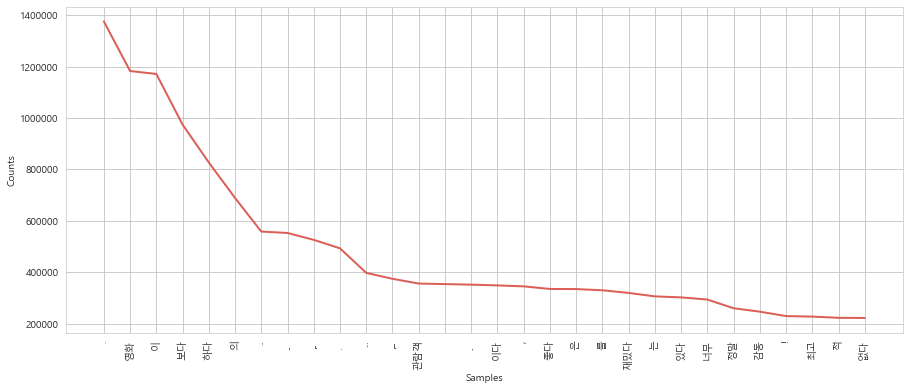

In [63]:
plt.figure(figsize=(15, 6))
text.plot(30)
plt.show()